## TRABALHO DE ANÁLISE DE SÉRIES TEMPORAIS E PREVISÃO

Este notebook está organizado da seguinte forma:
    
    Importar Bibliotecas
    Ler Ficheiro
    Data Preparation
    A. Estudo da estacionaridade da variável AQI
        A1. Logaritmizacao da serie original
        A2. Unit root tests
        A3. Calculo dos retornos - estacionarização da serie
    B. Modelos Estocásticos de Séries Temporais Uni-variados
        B1. Modelos ARMA/ARIMA/SARIMA
            B1.1 ARIMA
            B1.2 AUTO-ARIMA
            B1.3 SARIMAX from statsmodels
        B2. ARCH
    C. Estudo da estacionaridade de todas as variáveis
    D. Modelos Estocásticos de Séries Temporais Multivariados
        D1. Modelo VAR
    E. Deep Learning  
        E1. Modelo sem remoção dos outliers e com Rolling Windows
        E2. Modelo com remoção dos outliers e com Rolling Windows

## IMPORTAR BIBLIOTECAS

In [1]:
#!pip3 install --upgrade pip --user
#!pip3 install git+https://github.com/statsmodels/statsmodels
#!pip3 install git+https://github.com/statsmodels/statsmodels.git@maintenance/0.10.x
#!pip install plotly.express --user

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
import itertools
import math
from math import sqrt
import datetime

#SKLEARN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

##### Statsmodels
import statsmodels.tsa as smt
import statsmodels.api as sm
import statsmodels.tsa.arima_model as stm
import statsmodels.stats as sm_stat
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, acf, pacf #, pp
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse

#pmdarima
import pmdarima
import pmdarima as pm    ##### auto-arima
from pmdarima.metrics import smape

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Activation
from tensorflow.keras.callbacks import LearningRateScheduler
#!pip install tensorflow
#!pip install --upgrade pip --user
#!pip install keras --user

#arch
import arch as arch
from arch import arch_model
from arch.univariate import ARCH, GARCH, ARX
from arch.unitroot import PhillipsPerron

import warnings

warnings.filterwarnings("ignore")   ##### ignore warnings 
np.random.seed(1)
tf.random.set_seed(2)


## LER FICHEIRO

In [2]:
#df = pd.read_csv("C://Users//Guilherme//Desktop//pollution.csv", parse_dates=['Date'], index_col=0) ##Guilherme
#df = pd.read_csv("D://2ºsemestre//Analise de Series Tem//pollution.csv", parse_dates=['Date'], index_col=0)  ##Ana
#df = pd.read_csv("C://Users//maria//Downloads//pollution (2).csv", parse_dates=['Date'], index_col=0, encoding= 'unicode_escape')   ##Mariana
df = pd.read_csv("pollution.csv", parse_dates=['Date'], index_col=0) #Weidmam 
df1 = df #Backup

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31518 entries, 2015-08-01 00:00:00 to 2015-11-19 00:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Benzene         31518 non-null  float64
 1   CS2             31518 non-null  float64
 2   Ozone           31518 non-null  float64
 3   SO2             31518 non-null  float64
 4   Toluene         31518 non-null  float64
 5   Xylene          31518 non-null  float64
 6   Wind Direction  31497 non-null  float64
 7   Wind Speed      31497 non-null  float64
 8   Wind Origin     31497 non-null  object 
dtypes: float64(8), object(1)
memory usage: 2.4+ MB


In [4]:
df.head()

Benzene  CS2  Ozone  SO2  Toluene  Xylene  \
Date                                                             
2015-08-01 00:00:00      2.5  2.5  16.35  2.5      2.5     2.5   
2015-08-01 00:05:00      2.5  2.5  19.00  2.5      2.5     2.5   
2015-08-01 00:10:00      2.5  2.5  20.69  2.5      2.5     2.5   
2015-08-01 00:15:00      2.5  2.5  20.13  2.5      2.5     2.5   
2015-08-01 00:20:00      2.5  2.5  20.22  2.5      2.5     2.5   

                     Wind Direction  Wind Speed Wind Origin  
Date                                                         
2015-08-01 00:00:00           206.0         8.0         SSW  
2015-08-01 00:05:00           206.0         8.0         SSW  
2015-08-01 00:10:00           214.0         8.0         SSW  
2015-08-01 00:15:00           219.0         9.0          SW  
2015-08-01 00:20:00           219.0        11.0          SW

In [5]:
# Renomear as colunas com espaço no nome
df = df.rename(columns={"Wind Direction": "WindDirection", 
                        "Wind Speed": "WindSpeed", 
                        "Wind Origin": "WindOrigin"})

In [6]:
df.describe()

Benzene      CS2         Ozone           SO2       Toluene   Xylene  \
count  31518.0  31518.0  31518.000000  31518.000000  31518.000000  31518.0   
mean       2.5      2.5     26.970716      3.548762      2.616351      2.5   
std        0.0      0.0     10.432084      6.934469      1.379645      0.0   
min        2.5      2.5      2.500000      2.500000      2.500000      2.5   
25%        2.5      2.5     18.722500      2.500000      2.500000      2.5   
50%        2.5      2.5     26.010000      2.500000      2.500000      2.5   
75%        2.5      2.5     34.220000      2.500000      2.500000      2.5   
max        2.5      2.5    107.320000    313.310000     36.240000      2.5   

       WindDirection     WindSpeed  
count   31497.000000  31497.000000  
mean      172.029273      6.724640  
std        75.939725      3.249513  
min         0.000000      1.000000  
25%       140.000000      4.000000  
50%       162.000000      6.000000  
75%       207.000000      9.000000  
max       359.000000     26.000000

<h2> DATA PREPARATION

<h2> Tratamento dos valores não atribuídos

In [7]:
#soma dos NAS por coluna
print(df.isnull().sum())

Benzene           0
CS2               0
Ozone             0
SO2               0
Toluene           0
Xylene            0
WindDirection    21
WindSpeed        21
WindOrigin       21
dtype: int64


In [8]:
# Preenche os valores nulos com o valor da linha anterior
df=df.fillna(method='ffill')

In [9]:
df.count()

Benzene          31518
CS2              31518
Ozone            31518
SO2              31518
Toluene          31518
Xylene           31518
WindDirection    31518
WindSpeed        31518
WindOrigin       31518
dtype: int64

In [10]:
print(df.isnull().sum())

Benzene          0
CS2              0
Ozone            0
SO2              0
Toluene          0
Xylene           0
WindDirection    0
WindSpeed        0
WindOrigin       0
dtype: int64


<h2> Análise de Distribuição das Variáveis

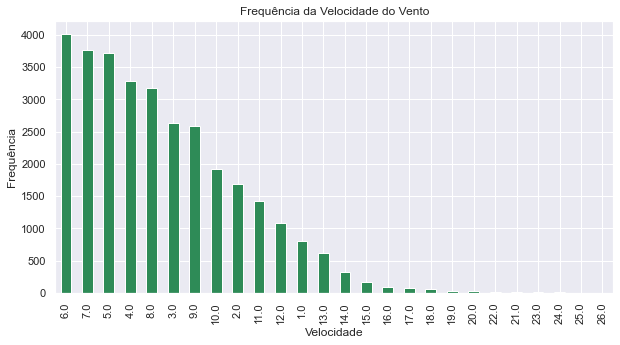

In [11]:
#Distribuição das variáveis
df.WindSpeed.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5), color = 'seagreen')
plt.title('Frequência da Velocidade do Vento')
plt.ylabel('Frequência')
plt.xlabel("Velocidade");

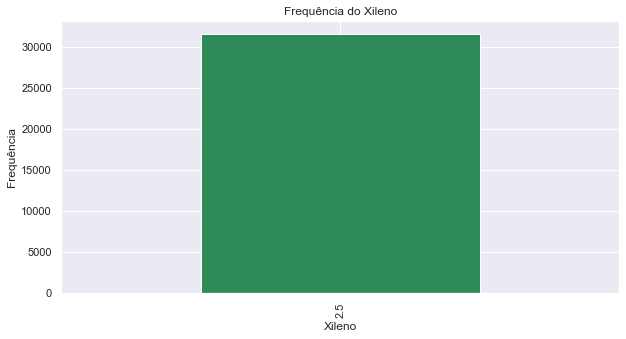

In [12]:
# Histograma do Xileno
df.Xylene.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5), color = 'seagreen')
plt.title('Frequência do Xileno')
plt.ylabel('Frequência')
plt.xlabel("Xileno");

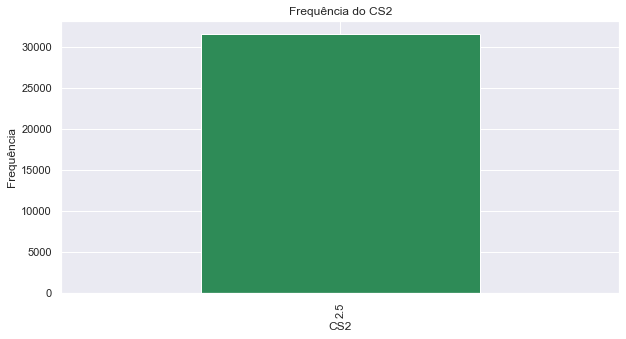

In [13]:
# Histograma do CS2
df.CS2.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5), color = 'seagreen')
plt.title('Frequência do CS2')
plt.ylabel('Frequência')
plt.xlabel("CS2");

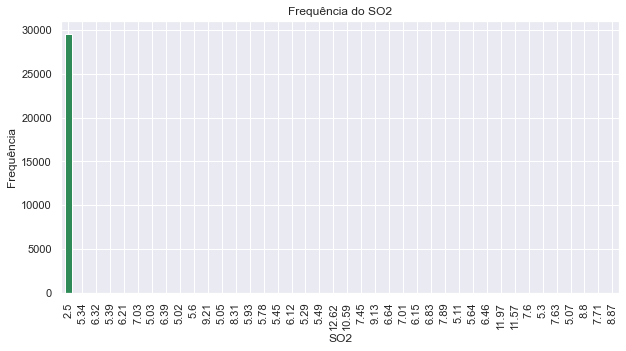

In [14]:
# Histograma do SO2
df.SO2.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5), color = 'seagreen')
plt.title('Frequência do SO2')
plt.ylabel('Frequência')
plt.xlabel("SO2");

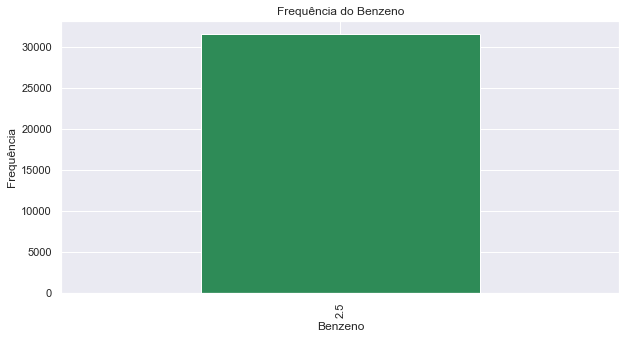

In [15]:
# Histograma do Benzene
df.Benzene.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5), color = 'seagreen')
plt.title('Frequência do Benzeno')
plt.ylabel('Frequência')
plt.xlabel("Benzeno");

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000299899C4E20>,
      dtype=object)

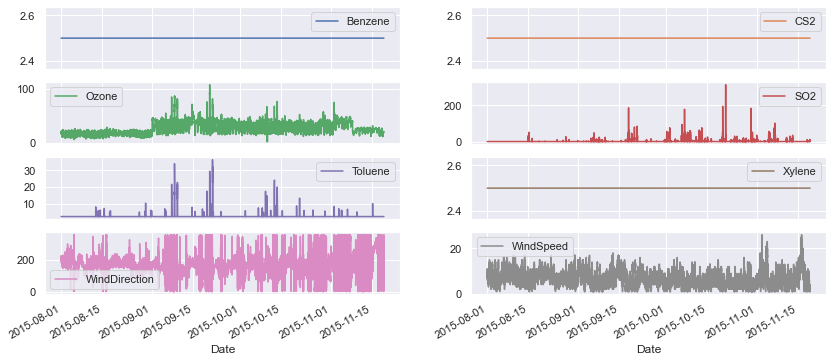

In [16]:
plt.rcParams["figure.figsize"] = (10,10)
df.plot(subplots=True, layout=(8,2), figsize=(14,12))

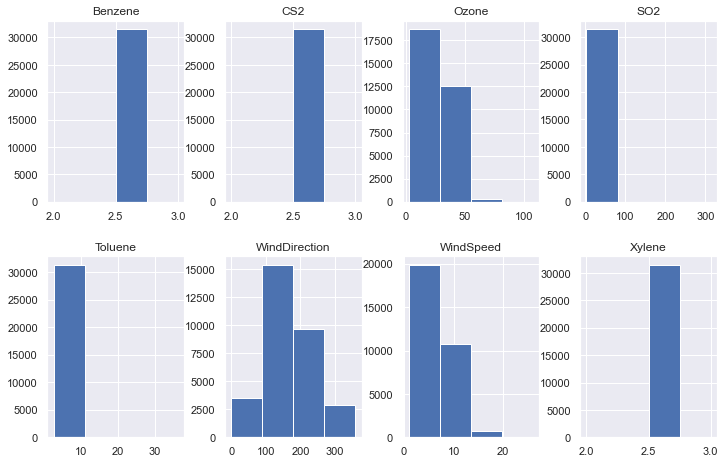

In [17]:
plt.rcParams["figure.figsize"] = (12,12)
hist = df.hist(bins=4, layout=(3,4))

In [18]:
df.describe()

Benzene      CS2         Ozone           SO2       Toluene   Xylene  \
count  31518.0  31518.0  31518.000000  31518.000000  31518.000000  31518.0   
mean       2.5      2.5     26.970716      3.548762      2.616351      2.5   
std        0.0      0.0     10.432084      6.934469      1.379645      0.0   
min        2.5      2.5      2.500000      2.500000      2.500000      2.5   
25%        2.5      2.5     18.722500      2.500000      2.500000      2.5   
50%        2.5      2.5     26.010000      2.500000      2.500000      2.5   
75%        2.5      2.5     34.220000      2.500000      2.500000      2.5   
max        2.5      2.5    107.320000    313.310000     36.240000      2.5   

       WindDirection     WindSpeed  
count   31518.000000  31518.000000  
mean      172.016879      6.723872  
std        75.922250      3.249109  
min         0.000000      1.000000  
25%       140.000000      4.000000  
50%       162.000000      6.000000  
75%       207.000000      9.000000  
max       359.000000     26.000000

##### Como o valor do  CS2, Xileno e Benzeno é o mesmo para todas as observações, faz sentido removar estas colunas.

In [19]:
df = df.drop(['CS2', 'Xylene',"Benzene"], axis=1)

In [20]:
df.head(5)

Ozone  SO2  Toluene  WindDirection  WindSpeed WindOrigin
Date                                                                         
2015-08-01 00:00:00  16.35  2.5      2.5          206.0        8.0        SSW
2015-08-01 00:05:00  19.00  2.5      2.5          206.0        8.0        SSW
2015-08-01 00:10:00  20.69  2.5      2.5          214.0        8.0        SSW
2015-08-01 00:15:00  20.13  2.5      2.5          219.0        9.0         SW
2015-08-01 00:20:00  20.22  2.5      2.5          219.0       11.0         SW

<h2> Análise  Temporal

Text(0.5, 1.0, 'Wind Speed Time Series')

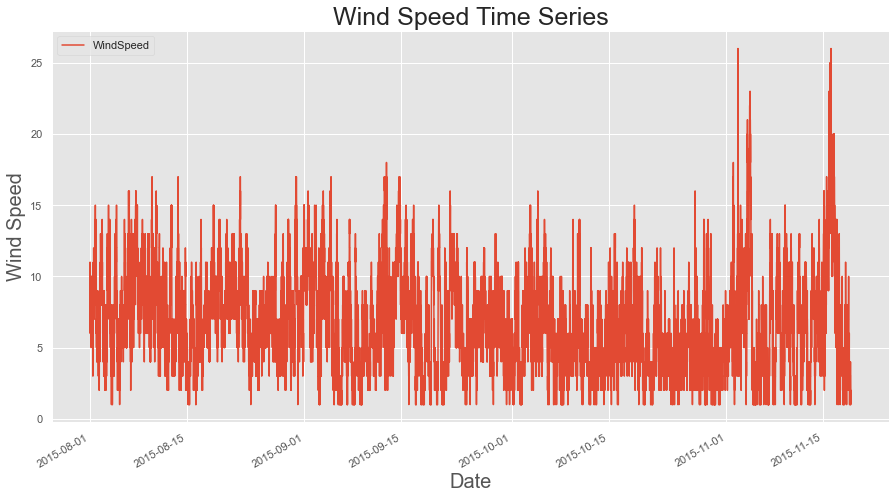

In [21]:
plt.style.use('ggplot')
ax = df[['WindSpeed']].plot( grid=True, figsize=(15,8))
ax.set_xlabel('Date', size = 20)
ax.set_ylabel('Wind Speed', size = 20)
ax.set_title('Wind Speed Time Series',size = 25)             


Text(0.5, 1.0, 'Ozone Time Series')

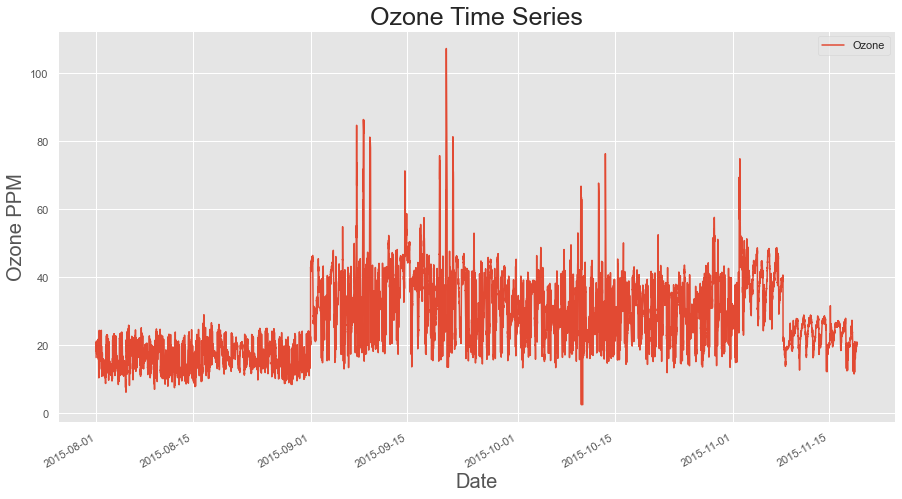

In [22]:
plt.style.use('ggplot')
ax = df[['Ozone']].plot( grid=True, figsize=(15,8))
ax.set_xlabel('Date', size = 20)
ax.set_ylabel('Ozone PPM', size = 20)
ax.set_title('Ozone Time Series',size = 25)    

Text(0.5, 1.0, 'Toluene Time Series')

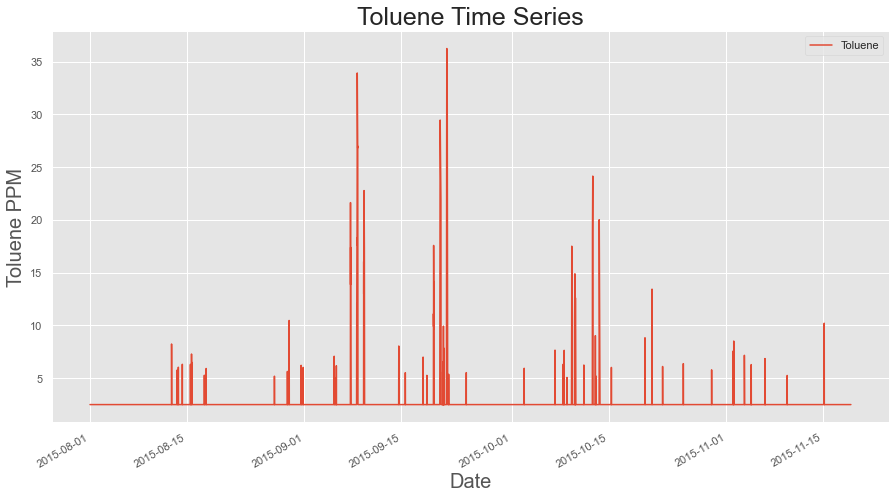

In [23]:
plt.style.use('ggplot')
ax = df[['Toluene']].plot( grid=True, figsize=(15,8))
ax.set_xlabel('Date', size = 20)
ax.set_ylabel('Toluene PPM', size = 20)
ax.set_title('Toluene Time Series',size = 25) 

Text(0.5, 1.0, 'SO2 Time Series')

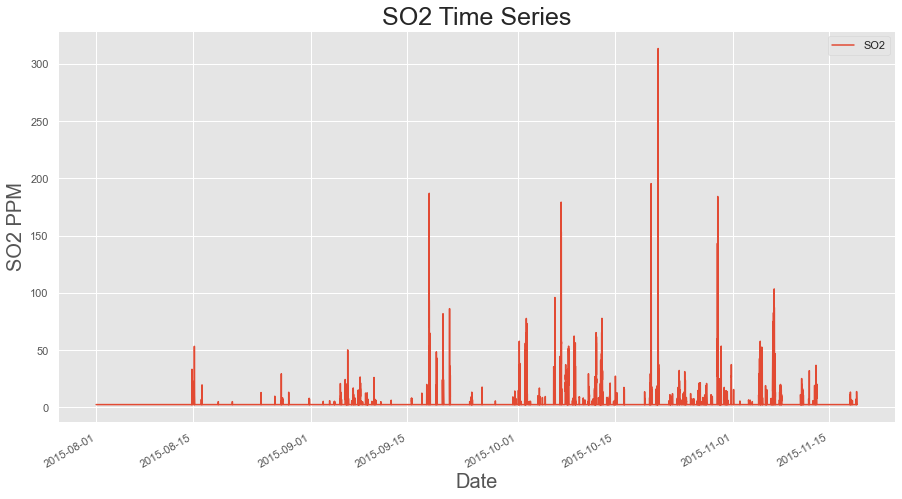

In [24]:
plt.style.use('ggplot')
ax = df[['SO2']].plot( grid=True, figsize=(15,8))
ax.set_xlabel('Date', size = 20)
ax.set_ylabel('SO2 PPM', size = 20)
ax.set_title('SO2 Time Series',size = 25) 

Text(0.5, 1.0, 'Wind Direction Time Series')

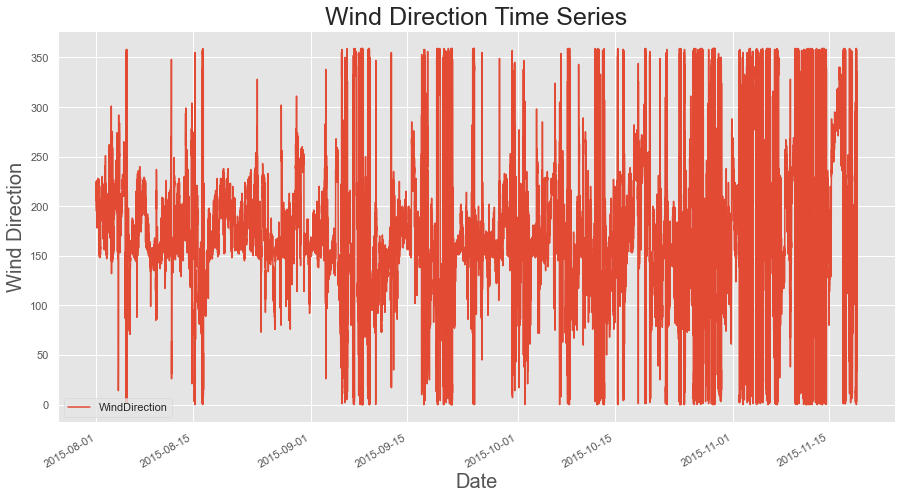

In [25]:
plt.style.use('ggplot')
ax = df[['WindDirection']].plot( grid=True, figsize=(15,8))
ax.set_xlabel('Date', size = 20)
ax.set_ylabel('Wind Direction', size = 20)
ax.set_title('Wind Direction Time Series',size = 25) 

## conversão da variável WindOrigin de categorica para numerica

In [26]:
#Atribui float para a variável WindOrigin
ord_enc = OrdinalEncoder()
df["WindOrigin_new"] = ord_enc.fit_transform(df[["WindOrigin"]])
df[["WindOrigin", "WindOrigin_new"]].head(10)

WindOrigin  WindOrigin_new
Date                                          
2015-08-01 00:00:00        SSW            11.0
2015-08-01 00:05:00        SSW            11.0
2015-08-01 00:10:00        SSW            11.0
2015-08-01 00:15:00         SW            12.0
2015-08-01 00:20:00         SW            12.0
2015-08-01 00:25:00         SW            12.0
2015-08-01 00:30:00        SSW            11.0
2015-08-01 00:35:00         SW            12.0
2015-08-01 00:40:00         SW            12.0
2015-08-01 00:45:00         SW            12.0

In [27]:
dfcorr=df.drop(columns=["WindOrigin"])

In [28]:
dfcorr.head()

Ozone  SO2  Toluene  WindDirection  WindSpeed  \
Date                                                                 
2015-08-01 00:00:00  16.35  2.5      2.5          206.0        8.0   
2015-08-01 00:05:00  19.00  2.5      2.5          206.0        8.0   
2015-08-01 00:10:00  20.69  2.5      2.5          214.0        8.0   
2015-08-01 00:15:00  20.13  2.5      2.5          219.0        9.0   
2015-08-01 00:20:00  20.22  2.5      2.5          219.0       11.0   

                     WindOrigin_new  
Date                                 
2015-08-01 00:00:00            11.0  
2015-08-01 00:05:00            11.0  
2015-08-01 00:10:00            11.0  
2015-08-01 00:15:00            12.0  
2015-08-01 00:20:00            12.0

<h2> Analise das correlações

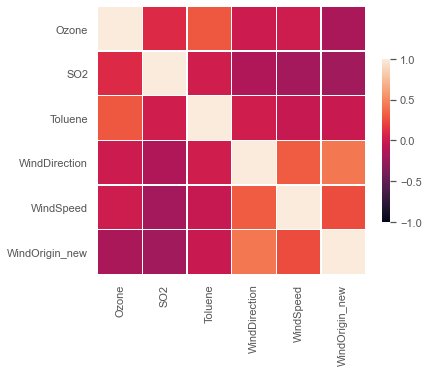

In [29]:
plt.rcParams["figure.figsize"] = (6,6)
ax = sns.heatmap(dfcorr.corr(), vmin=-1, vmax=1, 
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [30]:
dfcorr.corr()

Ozone       SO2   Toluene  WindDirection  WindSpeed  \
Ozone           1.000000  0.097311  0.298196       0.007464   0.015167   
SO2             0.097311  1.000000  0.029554      -0.134756  -0.192179   
Toluene         0.298196  0.029554  1.000000       0.030482  -0.019079   
WindDirection   0.007464 -0.134756  0.030482       1.000000   0.313541   
WindSpeed       0.015167 -0.192179 -0.019079       0.313541   1.000000   
WindOrigin_new -0.159438 -0.198362 -0.013392       0.430293   0.250216   

                WindOrigin_new  
Ozone                -0.159438  
SO2                  -0.198362  
Toluene              -0.013392  
WindDirection         0.430293  
WindSpeed             0.250216  
WindOrigin_new        1.000000

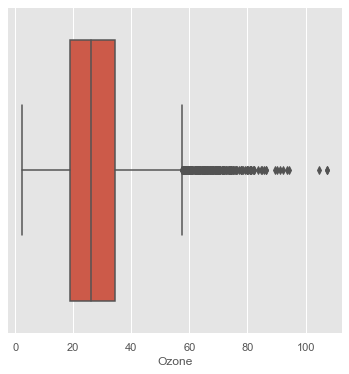

In [31]:
#sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df["Ozone"])

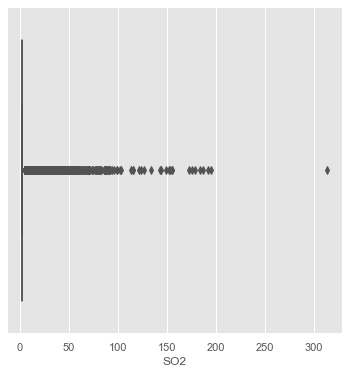

In [32]:
ax = sns.boxplot(x=df["SO2"])

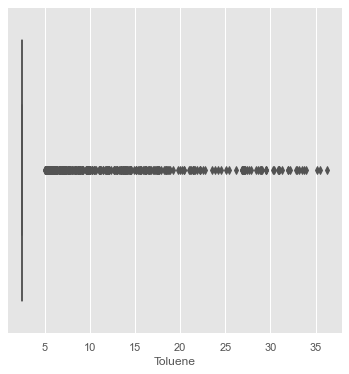

In [33]:
ax = sns.boxplot(x=df["Toluene"])

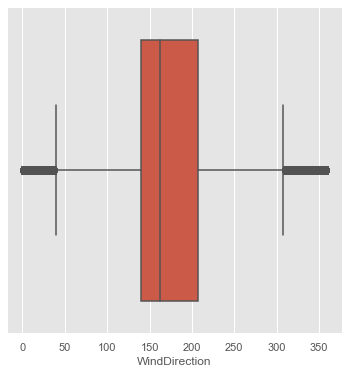

In [34]:
ax = sns.boxplot(x=df["WindDirection"])

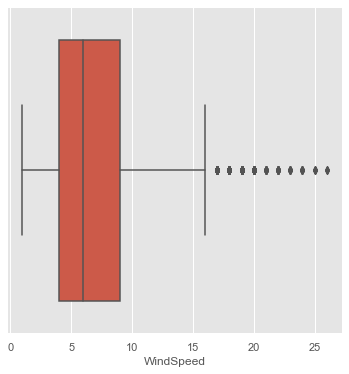

In [35]:
ax = sns.boxplot(x=df["WindSpeed"])

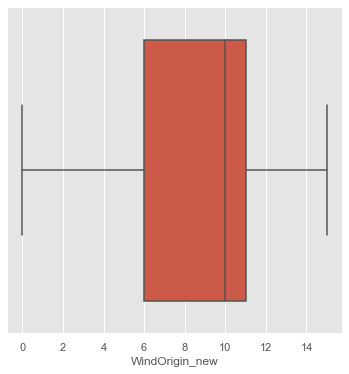

In [36]:
ax = sns.boxplot(x=df["WindOrigin_new"])

<h2> Criação do indice de poluição com base no Ozono

In [37]:
AQI=[]
for x in df["Ozone"]:
    if x>=0 and x<=54:
        AQI.append(round(((50-0)/(54-0))*(x-0)+0,3))
    if x>54 and x<=70:
        AQI.append(round(((100-51)/(70-55))*(x-55)+51,3))
    if x>70 and x<=85:
        AQI.append(round(((150-101)/(85-71))*(x-71)+101,3))
    if x>85 and x<=105:
        AQI.append(round(((200-151)/(105-86))*(x-86)+151,3))
    if x>105 and x<=200:
        AQI.append(round(((300-201)/(200-106))*(x-106)+201,3))

In [38]:
df['AQI'] =AQI

In [39]:
Category=[]
for x in df["AQI"]:
    if x>=0 and x<=50:
        Category.append("Good")
    if x>50 and x<=100:
        Category.append("Moderate")
    if x>100 and x<=150:
        Category.append("Unhealthy_for_Sensitive_Groups")
    if x>150 and x<=200:
        Category.append("Unhealthy")
    if x>200 and x<=300:
        Category.append("Very_Unhealthy")

In [40]:
df['Category']=Category

In [41]:
df

Ozone  SO2  Toluene  WindDirection  WindSpeed WindOrigin  \
Date                                                                            
2015-08-01 00:00:00  16.35  2.5      2.5          206.0        8.0        SSW   
2015-08-01 00:05:00  19.00  2.5      2.5          206.0        8.0        SSW   
2015-08-01 00:10:00  20.69  2.5      2.5          214.0        8.0        SSW   
2015-08-01 00:15:00  20.13  2.5      2.5          219.0        9.0         SW   
2015-08-01 00:20:00  20.22  2.5      2.5          219.0       11.0         SW   
...                    ...  ...      ...            ...        ...        ...   
2015-11-18 23:40:00  20.87  2.5      2.5          154.0        2.0        SSE   
2015-11-18 23:45:00  20.67  2.5      2.5          113.0        1.0        ESE   
2015-11-18 23:50:00  20.61  2.5      2.5          107.0        2.0        ESE   
2015-11-18 23:55:00  20.59  2.5      2.5          100.0        2.0          E   
2015-11-19 00:00:00  20.47  2.5      2.5           86.0        2.0          E   

                     WindOrigin_new     AQI Category  
Date                                                  
2015-08-01 00:00:00            11.0  15.139     Good  
2015-08-01 00:05:00            11.0  17.593     Good  
2015-08-01 00:10:00            11.0  19.157     Good  
2015-08-01 00:15:00            12.0  18.639     Good  
2015-08-01 00:20:00            12.0  18.722     Good  
...                             ...     ...      ...  
2015-11-18 23:40:00            10.0  19.324     Good  
2015-11-18 23:45:00             2.0  19.139     Good  
2015-11-18 23:50:00             2.0  19.083     Good  
2015-11-18 23:55:00             0.0  19.065     Good  
2015-11-19 00:00:00             0.0  18.954     Good  

[31518 rows x 9 columns]

In [42]:
dfcorr['AQI'] =AQI

In [43]:
dfcorr.corr()

Ozone       SO2   Toluene  WindDirection  WindSpeed  \
Ozone           1.000000  0.097311  0.298196       0.007464   0.015167   
SO2             0.097311  1.000000  0.029554      -0.134756  -0.192179   
Toluene         0.298196  0.029554  1.000000       0.030482  -0.019079   
WindDirection   0.007464 -0.134756  0.030482       1.000000   0.313541   
WindSpeed       0.015167 -0.192179 -0.019079       0.313541   1.000000   
WindOrigin_new -0.159438 -0.198362 -0.013392       0.430293   0.250216   
AQI             0.963123  0.081646  0.480911       0.024290   0.018790   

                WindOrigin_new       AQI  
Ozone                -0.159438  0.963123  
SO2                  -0.198362  0.081646  
Toluene              -0.013392  0.480911  
WindDirection         0.430293  0.024290  
WindSpeed             0.250216  0.018790  
WindOrigin_new        1.000000 -0.145629  
AQI                  -0.145629  1.000000

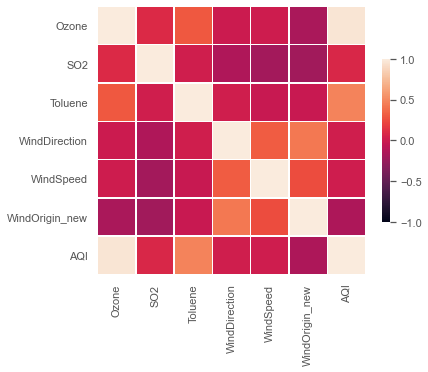

In [44]:
ax = sns.heatmap(dfcorr.corr(), vmin=-1, vmax=1, 
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [45]:
dfready=dfcorr.drop(columns=["Ozone"])

In [46]:
dfready

SO2  Toluene  WindDirection  WindSpeed  WindOrigin_new  \
Date                                                                          
2015-08-01 00:00:00  2.5      2.5          206.0        8.0            11.0   
2015-08-01 00:05:00  2.5      2.5          206.0        8.0            11.0   
2015-08-01 00:10:00  2.5      2.5          214.0        8.0            11.0   
2015-08-01 00:15:00  2.5      2.5          219.0        9.0            12.0   
2015-08-01 00:20:00  2.5      2.5          219.0       11.0            12.0   
...                  ...      ...            ...        ...             ...   
2015-11-18 23:40:00  2.5      2.5          154.0        2.0            10.0   
2015-11-18 23:45:00  2.5      2.5          113.0        1.0             2.0   
2015-11-18 23:50:00  2.5      2.5          107.0        2.0             2.0   
2015-11-18 23:55:00  2.5      2.5          100.0        2.0             0.0   
2015-11-19 00:00:00  2.5      2.5           86.0        2.0             0.0   

                        AQI  
Date                         
2015-08-01 00:00:00  15.139  
2015-08-01 00:05:00  17.593  
2015-08-01 00:10:00  19.157  
2015-08-01 00:15:00  18.639  
2015-08-01 00:20:00  18.722  
...                     ...  
2015-11-18 23:40:00  19.324  
2015-11-18 23:45:00  19.139  
2015-11-18 23:50:00  19.083  
2015-11-18 23:55:00  19.065  
2015-11-19 00:00:00  18.954  

[31518 rows x 6 columns]

Text(0.5, 1.0, 'AQI Time Series')

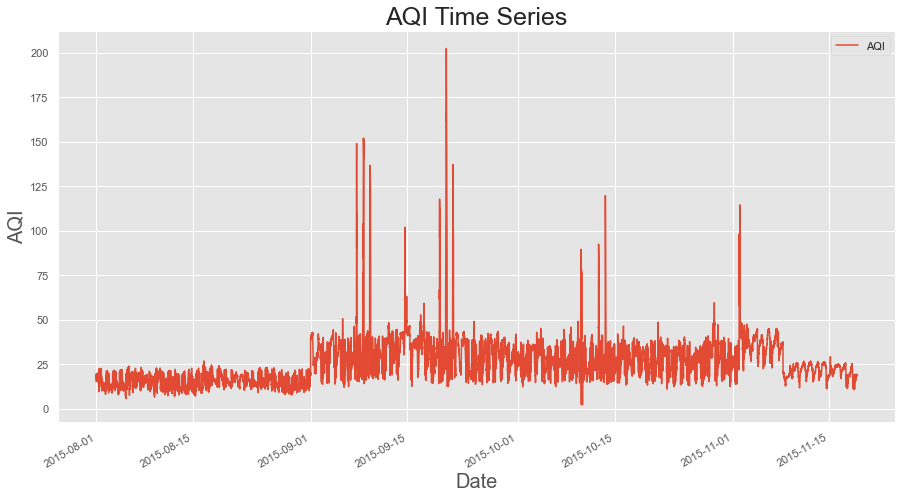

In [47]:
plt.style.use('ggplot')
ax = df[['AQI']].plot( grid=True, figsize=(15,8))
ax.set_xlabel('Date', size = 20)
ax.set_ylabel('AQI', size = 20)
ax.set_title('AQI Time Series',size = 25) 

<h1> A. Estudo da estacionaridade da variável AQI

In [48]:
dfAQI=df["AQI"]

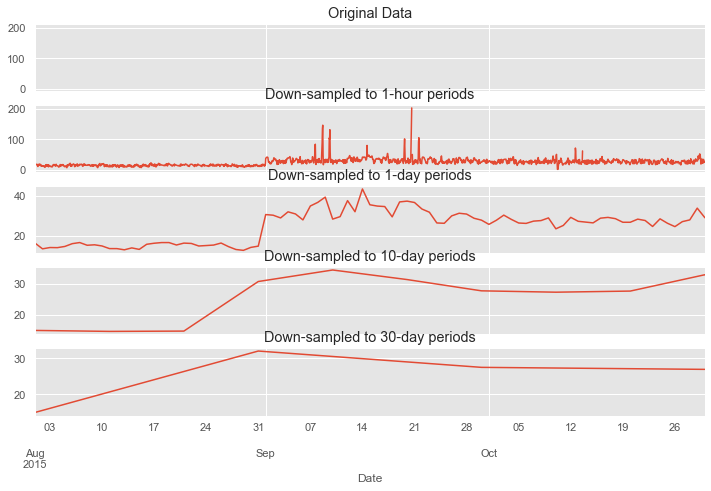

In [49]:
fig, ax = plt.subplots(5, sharex=True)
dfAQI.plot(figsize=(12,8), ax=ax[0], title="Original Data",
legend=False)
dfAQI.resample('1H').mean().plot(figsize=(12,8), ax=ax[1],
title="Down-sampled to 1-hour periods",legend=False)
dfAQI.resample('1D').mean().plot(figsize=(12,8), ax=ax[2],
title="Down-sampled to 1-day periods",legend=False)
dfAQI.resample('10D').mean().plot(figsize=(12,8), ax=ax[3],
title="Down-sampled to 10-day periods",legend=False)
dfAQI.resample('30D').mean().plot(figsize=(12,8), ax=ax[4],
title="Down-sampled to 30-day periods",legend=False)
plt.show()

In [50]:
dfAQI=dfAQI.resample('1D').mean()

In [51]:
dfAQI=dfAQI.to_frame()

In [52]:
dfAQI.head()

AQI
Date                 
2015-08-01  16.351424
2015-08-02  13.504069
2015-08-03  14.150691
2015-08-04  14.092559
2015-08-05  14.696507

In [53]:
#dfAQI.info()

<h2> A1 . Logaritmizacao da serie original

<Figure size 432x432 with 0 Axes>

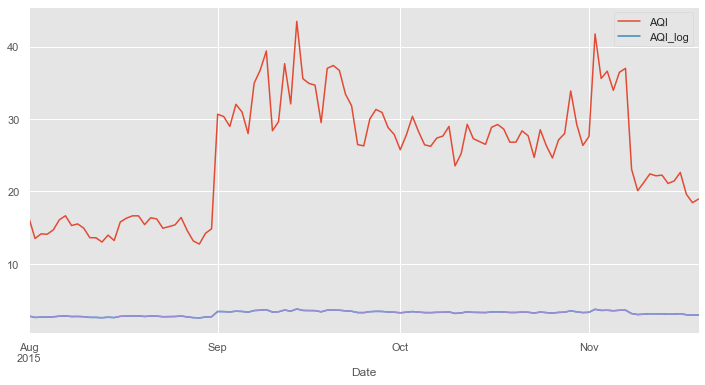

In [54]:
# log values of AQI time series
AQI_log = np.log(dfAQI['AQI'])

# add new log time series to dataframe
dfAQI['AQI_log'] = AQI_log

# plot both time series
plt.figure() 
dfAQI.plot(figsize=(12, 6))
dfAQI['AQI_log'].plot(figsize=(12, 6))
plt.show()
# bad plot - time series with different scale

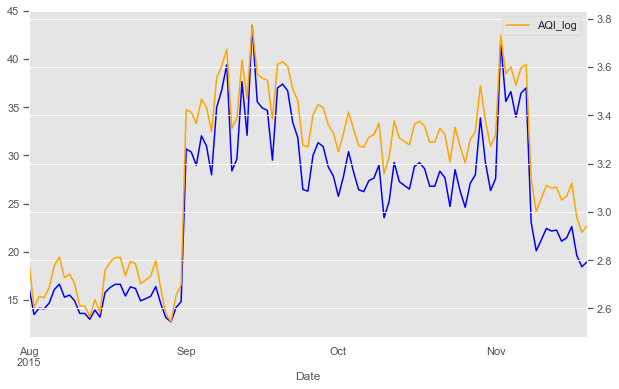

<Figure size 432x432 with 0 Axes>

In [55]:
# better plot
# # make a plot with different y-axis using second axis object ('secondary_y')

plt.figure(figsize=(10,6))
dfAQI['AQI'].plot(color="blue", label = 'AQI')
dfAQI['AQI_log'].plot(secondary_y = True, color="orange", label = 'AQI_log')
plt.legend(loc = 'best')
plt.show()
plt.savefig('AQIvsAQILog.png', transparent=True)
# observe the 2 y-axis with different scales

Text(0.5, 1.0, 'Histograma serie log')

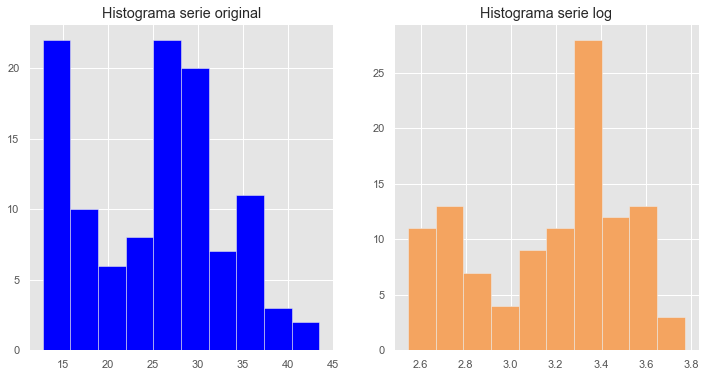

In [56]:
# Analise dos histogramas
plt.subplot(121)
dfAQI['AQI'].hist(figsize=(12,6), color="blue")
plt.title('Histograma serie original')
plt.subplot(122)
dfAQI['AQI_log'].hist(figsize=(12,6), color="sandybrown")
plt.title('Histograma serie log')


In [57]:
#Análise da variancia
## Divisao da amostra em 2 metades
X = dfAQI['AQI_log'].values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3.054056, mean2=3.294042
variance1=0.164870, variance2=0.029264


<h3> Verificação visual da estacionaridade da série logaritimizada

Plot the rolling mean and rolling standard deviation. The time
series is stationary if they remain constant with time (with the naked eye look to see
if the lines are straight and parallel to the x-axis).

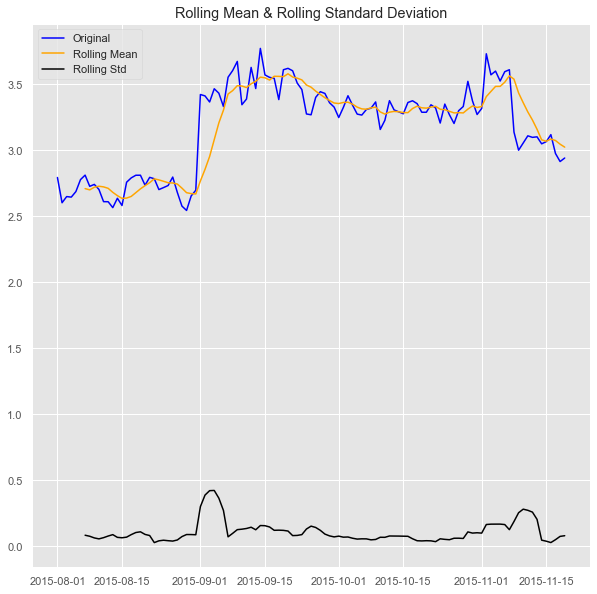

In [58]:
plt.rcParams["figure.figsize"] = (10,10)
rolling_mean = AQI_log.rolling(window = 7).mean()
rolling_std = AQI_log.rolling(window = 7).std()
plt.plot(AQI_log, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'orange', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')

plt.show()

Visualmente a série é não estacionária, desvio padrão e média não constantes.

<h2> A2. Unit root tests

- Stationarity is one of the basic building blocks of performing a time series analysis ortime series forecasting.
- statistical modeling methods assume or require the time series to be stationaryto be effective.
- The summary statistics of a stationary time series will remain constant or varyminimally over time. e.g. mean and variance
- "Types" of stationary:
    - Trend Stationary: A time series that does not exhibit a trend.
    - Seasonal Stationary: A time series that does not exhibit seasonality.
    - Strictly Stationary: A mathematical definition of a stationary process, specifically that the joint distribution of observations is invariant to time shift.
- If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals. 
- The statistical tests to analyse non-stationarity/ stationarity are called unit root tests /stationarity teste
- Unit root test H0: exists a unit root = non-stationary time-series (e. g., Augmented Dickey-Fuller ou ADF test, PP test)
- Stationarity test H0: stationary time series (e.g. KPss test)
- Reject the null if **p-value < 0.05** (where 0.05 is 5% significance level)

In [59]:

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1]> 0.05:
        print("We do not reject the H0: non-stationary time series <-> we have a unit root")
    else:
        print("We  reject the H0: stationary time series <-> we have a unit root")
        
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1]> 0.05:
        print("We do not reject the H0: stationary time series <-> we have a unit root")
    else:
        print("We reject the H0: non stationary time series")
        
def pp_test(timeseries):
    pptest = PhillipsPerron(timeseries, trend='c')
    print(pptest.summary().as_text())


<h3> a) Verificação da estacionaridade para série original

In [60]:
dfAQI

AQI   AQI_log
Date                           
2015-08-01  16.351424  2.794315
2015-08-02  13.504069  2.602991
2015-08-03  14.150691  2.649763
2015-08-04  14.092559  2.645647
2015-08-05  14.696507  2.687610
...               ...       ...
2015-11-15  21.457219  3.066061
2015-11-16  22.624194  3.119020
2015-11-17  19.612392  2.976162
2015-11-18  18.455226  2.915348
2015-11-19  18.954000  2.942015

[111 rows x 2 columns]

In [61]:
adf1=adf_test(dfAQI["AQI"])
adf1

Results of Dickey-Fuller Test:
Test Statistic                  -2.317045
p-value                          0.166530
#Lags Used                       1.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64
We do not reject the H0: non-stationary time series <-> we have a unit root


In [62]:
kpss1 = kpss_test(dfAQI["AQI"])
kpss1

Results of KPSS Test:
Test Statistic           0.687228
p-value                  0.014707
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
We reject the H0: non stationary time series


In [63]:
pp1 = pp_test(dfAQI["AQI"])

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.587
P-value                         0.096
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Os 3 testes concordam que a série é não estacionária.

<h3>b) Unit root tests - verificação da estacionaridade para série logaritmizada

In [64]:
adf1=adf_test(dfAQI["AQI_log"])
adf1

Results of Dickey-Fuller Test:
Test Statistic                  -2.226928
p-value                          0.196618
#Lags Used                       0.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64
We do not reject the H0: non-stationary time series <-> we have a unit root


In [65]:
kpss2 = kpss_test(dfAQI["AQI_log"])
kpss2

Results of KPSS Test:
Test Statistic           0.718559
p-value                  0.011858
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
We reject the H0: non stationary time series


In [66]:
pp2 = pp_test(dfAQI["AQI_log"])

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.082
P-value                         0.252
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Como P-Value > 0.05  --> não rejeitamos H0.
Logo, a serie LOG é não estacionária.

Os três testes de raíz unitária concordam que a série logaritmizada é não estacionária.

<h2> A3. Calculo dos retornos - estacionarização da serie

In [67]:
AQI_log_returns = np.log(dfAQI['AQI']).diff().dropna() # assume que é diff de ordem 1


In [68]:
AQI_log_returns.head()

Date
2015-08-02   -0.191324
2015-08-03    0.046772
2015-08-04   -0.004117
2015-08-05    0.041963
2015-08-06    0.090802
Freq: D, Name: AQI, dtype: float64

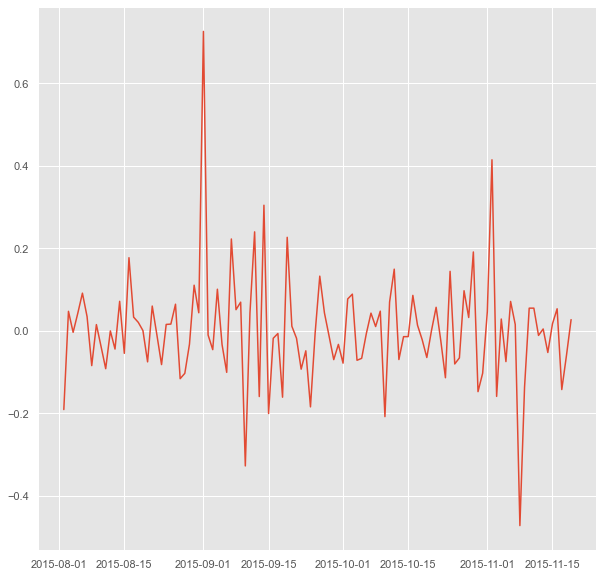

In [69]:
plt.plot(AQI_log_returns)
plt.show()
#plt.rcParams["figure.figsize"] = (15,6)

<b> Analise da estacionaridade dos retornos

In [70]:
adf_test(AQI_log_returns)

Results of Dickey-Fuller Test:
Test Statistic                -1.177961e+01
p-value                        1.042440e-21
#Lags Used                     0.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (1%)           -3.491818e+00
Critical Value (5%)           -2.888444e+00
Critical Value (10%)          -2.581120e+00
dtype: float64
We  reject the H0: stationary time series <-> we have a unit root


In [71]:
kpss_test(AQI_log_returns)

Results of KPSS Test:
Test Statistic           0.160735
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
We do not reject the H0: stationary time series <-> we have a unit root


In [72]:
pp_test(AQI_log_returns)     

     Phillips-Perron Test (Z-tau)    
Test Statistic                -12.468
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Os 3 testes concordam que a serie diferenciada e estacionaria. Concluimos assim que a serie AQI é integrada de ordem 1.

In [73]:
# Verificacao da existencia de valores nulos
dfAQI.isna().sum()

AQI        0
AQI_log    0
dtype: int64

## Correlogram: ACF and PACF

- **ACF** is an (complete) auto-correlation function which gives us values of auto-correlationof any series with its lagged values
- In simple terms, it describes how well the present valueof the series is related with its past values. 
- A time series can have components like trend,seasonality, cyclic and residual. ACF considers all these components while findingcorrelations hence it’s a ‘complete auto-correlation plot’.
- **PACF** is a partial auto-correlation function. 
- Basically instead of finding correlations ofpresent with lags like ACF, it finds correlation of the residuals (which remains afterremoving the effects which are already explained by the earlier lag(s)) with the next lagvalue hence ‘partial’ and not ‘complete’ as we remove already found variations before wefind the next correlation.
- So if there is any hidden information in the residual which canbe modeled by the next lag, we might get a good correlation and we will keep that nextlag as a feature while modeling.

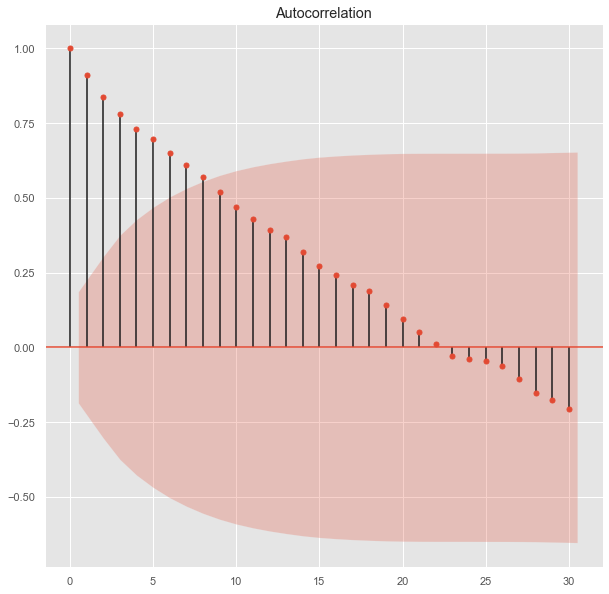

In [74]:
#Auto correlacao para a serie logaritmizada
plot_acf(AQI_log, lags=30, alpha=0.05)
plt.show()


In [75]:
#Não tem padrão de sazonalidade

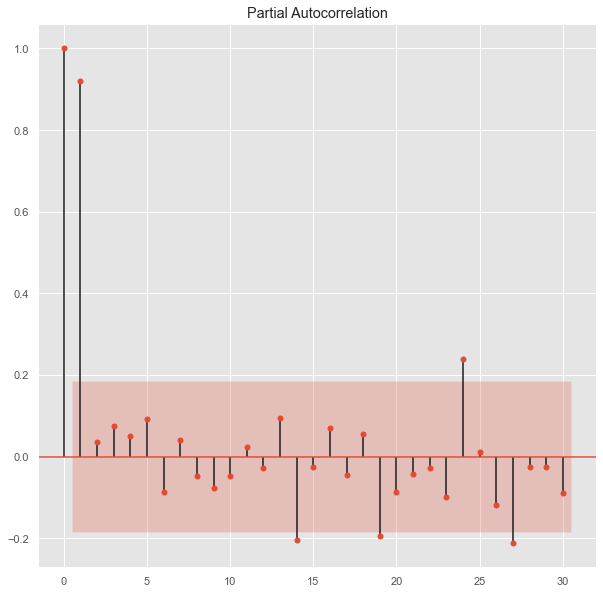

In [76]:
#Auto correlacao parcial para a serie logaritmizada
plot_pacf(AQI_log, lags=30, alpha=0.05)
plt.show()


In [77]:
#Tem 2 picos significativos e depois converge para 0.

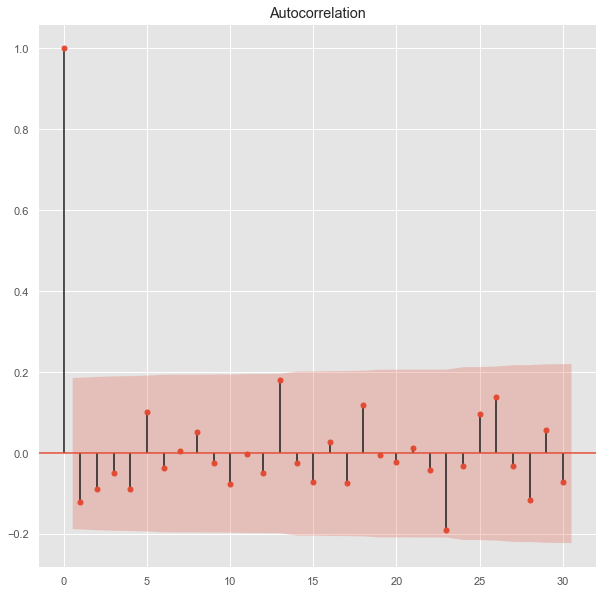

In [78]:
#Auto correlacao para a serie diferenciada
plot_acf(AQI_log_returns, lags=30, alpha=0.05)
plt.show()


In [79]:
#Não tem sazonalidade, tem apenas 1 pico significativa e depois converge para 0.

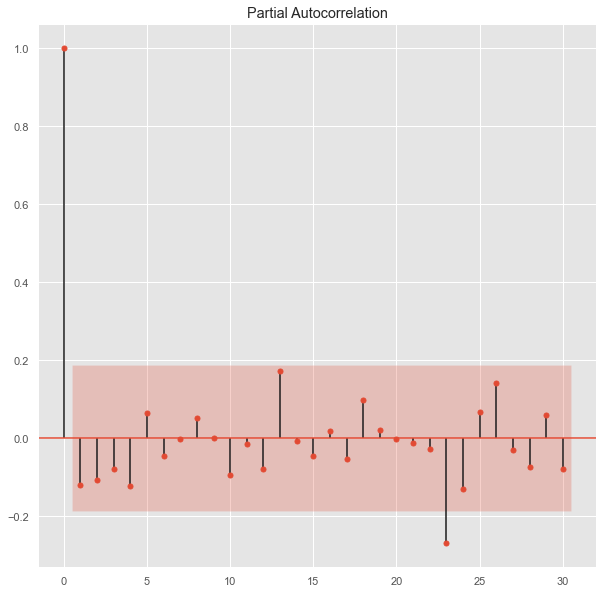

In [80]:
#Auto correlacao parcial para a serie diferenciada
plot_pacf(AQI_log_returns, lags=30, alpha=0.05)
plt.show()


In [81]:
# A analise  dos 2 graficos é tipico de ruido branco, o primeiro elemento é 1 e os restante são 0. 

<h1> B. Modelos Estocásticos de Séries Temporais Uni-variados

<h2> Divisao em conjunto de treino e teste

In [82]:
# Create Training and Test (only for original AQI time series)
dfAQI2=dfAQI['AQI']

In [83]:
dfAQI2

Date
2015-08-01    16.351424
2015-08-02    13.504069
2015-08-03    14.150691
2015-08-04    14.092559
2015-08-05    14.696507
                ...    
2015-11-15    21.457219
2015-11-16    22.624194
2015-11-17    19.612392
2015-11-18    18.455226
2015-11-19    18.954000
Freq: D, Name: AQI, Length: 111, dtype: float64

In [84]:
train_data = dfAQI2['2015-08-01':'2015-10-27']
test_data = dfAQI2['2015-10-28':'2015-11-19']

In [85]:
# number of observations of the sets
print("Tamanho conjunto de treino:", len(train_data), "Dimensao:",train_data.shape)
print("Tamanho conjunto de teste:", len(test_data), "Dimensao:", test_data.shape)

Tamanho conjunto de treino: 88 Dimensao: (88,)
Tamanho conjunto de teste: 23 Dimensao: (23,)


<h2> a) Unit root tests - verificação da estacionaridade para o conjunto de treino

In [86]:
adf3=adf_test(train_data)
adf3

Results of Dickey-Fuller Test:
Test Statistic                 -1.710209
p-value                         0.425860
#Lags Used                      7.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64
We do not reject the H0: non-stationary time series <-> we have a unit root


In [87]:
kpss3 = kpss_test(train_data)
kpss3

Results of KPSS Test:
Test Statistic           0.839434
p-value                  0.010000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
We reject the H0: non stationary time series


In [88]:
pp3 = pp_test(train_data)
pp3

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.008
P-value                         0.283
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.51 (1%), -2.90 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


<b> Como P-Value > 0.05  --> rejeitamos H0. Logo, a serie diferenciada é não estacionária

<h2> B1. Modelos ARMA/ARIMA/SARIMA 

<h3> B1.1  ARIMA 

- The ARIMA model takes in three parameters:
    - 1. p is the order of the AR term
    - 2. q is the order of the MA term
    - 3. d is the number of differencing
    
    Seasonal ARIMA model. Here, the order argument specifies the
(p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal
component of the Seasonal ARIMA model.

<h4> ARIMA para a serie residual, sem tendencia e sem sazonalidade

In [89]:
# Now we want to check our data with this simple ARIMA(1,0,0) model
mod1 = ARIMA(AQI_log_returns, order=(1,0,0))
result1=mod1.fit()
#result1.summary()

-p-value const=0.894> 0.05 --> não rejeitamos hipotese nula

-p-value ar.L1 =0.203> 0.05 --> não rejeitamos hipotese nula --> O termo autoregressivo de ordem 1 não é estatisticamente significativo.   --> o modelo não é ok

In [90]:
# Now we want to check our data with this simple ARIMA(0,0,1) model
mod2 = ARIMA(AQI_log_returns, order=(0,0,1))
result2=mod2.fit()
#result2.summary()

-p-value const=0.882> 0.05 --> não rejeitamos hipotese nula

-p-value ma.L1 =0.150> 0.05 --> não rejeitamos hipotese nula --> O termo autoregressivo de ordem 1 não é estatisticamente significativo.   --> o modelo não é ok


In [91]:
# Now we want to check our data with this simple ARIMA(1,0,1) model
mod3 = ARIMA(AQI_log_returns, order=(1,0,1))
result3=mod3.fit()
#result3.summary()

-p-value const=0.803> 0.05 --> não rejeitamos hipotese nula

-p-value ar.L1 =0.056> 0.05 -->   não rejeitamos hipotese nula --> O termo autoregressivo de ordem 1 não é estatisticamente significativo.   --> o modelo não é ok

-p-value ma.L1 =0.003< 0.05 --> rejeitamos hipotese nula --> O termo media movel de ordem 1  é estatisticamente significativo.


In [92]:
# Now we want to check our data with this simple ARIMA(0,0,1) model
mod4 = ARIMA(AQI_log_returns, order=(0,0,1))
result4=mod4.fit()
#result4.summary()

-p-value const=0.882> 0.05 --> não rejeitamos hipotese nula

-p-value ma.L1 =0.150> 0.05 --> nao rejeitamos hipotese nula --> O termo media movel de ordem 1  não é estatisticamente significativo.


In [93]:
# Now we want to check our data with this simple ARIMA(0,0,2) model
mod5 = ARIMA(AQI_log_returns, order=(0,0,2))
result5=mod5.fit()
#result5.summary()

-p-value const=0.338> 0.05 --> não rejeitamos hipotese nula

-p-value ma.L1 =0.107> 0.05 --> não rejeitamos hipotese nula --> O termo media movel de ordem 1 não  é estatisticamente significativo.

-p-value ma.L2 =0.206> 0.05 --> não rejeitamos hipotese nula --> O termo media movel de ordem 2 não  é estatisticamente significativo.


In [94]:
# Now we want to check our data with this simple ARIMA(1,0,1) model
mod6 = ARIMA(AQI_log_returns, order=(1,0,1))
result6=mod6.fit()
#result6.summary()

-p-value const=0.803> 0.05 --> não rejeitamos hipotese nula

-p-value ar.L1 =0.056> 0.05 --> não rejeitamos hipotese nula --> O termo auto regresivo de ordem 1 não  é estatisticamente significativo.

-p-value ma.L1 =0.003< 0.05 --> rejeitamos hipotese nula --> O termo media movel de ordem 1  é estatisticamente significativo.


In [95]:
# Now we want to check our data with this simple ARIMA(2,0,0) model
mod7 = ARIMA(AQI_log_returns, order=(2,0,0))
result7=mod7.fit()
#result7.summary()

-p-value const=0.872> 0.05 --> não rejeitamos hipotese nula

-p-value ar.L1 =0.161> 0.05 --> não rejeitamos hipotese nula --> O termo auto regresivo de ordem 1 não  é estatisticamente significativo.

-p-value ar.L2 =0.265> 0.05 -->  não rejeitamos hipotese nula --> O termo auto regresivo de ordem 2 não  é estatisticamente significativo.


In [96]:
# Now we want to check our data with this simple ARIMA(2,0,1) model
mod8 = ARIMA(AQI_log_returns, order=(2,0,1))
result8=mod8.fit()
#result8.summary()

-p-value const=0.811> 0.05 --> não rejeitamos hipotese nula

-p-value ar.L1 =0.195> 0.05 --> não rejeitamos hipotese nula --> O termo auto regresivo de ordem 1 não  é estatisticamente significativo.

-p-value ar.L2 =0.729> 0.05 -->  não rejeitamos hipotese nula --> O termo auto regresivo de ordem 2 não  é estatisticamente significativo.

-p-value ma.L1 =0.080> 0.05 -->  não rejeitamos hipotese nula --> O termo media movel de ordem 1 não  é estatisticamente significativo.


In [97]:
# Now we want to check our data with this simple ARIMA(0,1,1) model
mod9 = ARIMA(AQI_log_returns, order=(0,1,1))
result9=mod9.fit()
result9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.AQI   No. Observations:                  109
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  61.462
Method:                       css-mle   S.D. of innovations              0.135
Date:                Tue, 22 Jun 2021   AIC                           -116.924
Time:                        11:42:06   BIC                           -108.850
Sample:                    08-03-2015   HQIC                          -113.650
                         - 11-19-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.000     -0.753      0.451      -0.001       0.000
ma.L1.D.AQI    -1.0000      0.025    -40.377      0.000      -1.048      -0.951
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

-p-value const=0.451> 0.05 --> não rejeitamos hipotese nula

-p-value ma.L1 =0.000< 0.05 -->  rejeitamos hipotese nula --> O termo media movel de ordem 1  é estatisticamente significativo.  --> o modelo não é ok


<b> Estudo dos residuos do melhor modelo

- The final part of modelling a time series is to study the residuals.
- Ideally, the residuals will be white noise, with no autocorrelation.
- A good way to test this is to use the Ljung-Box test. Note that this test can only be applied to the residuals.
- Here, the null hypothesis for the Ljung-Box test is that there is no autocorrelation.
- White noise, by definition, is random data. A time series is white noise(random) if the variables are independent and identically distributed(i.i.d) with a mean of zero. In other words, the time series has a mean μ = 0 and a constant standard deviation σ = c.

<b> Estudo dos residuos do melhor modelo

In [98]:
#escolhemos o melhor modelo - modelo 4

# Ljung-Box test
acorr_ljungbox(result9.resid, lags=[5], return_df=True)


lb_stat  lb_pvalue
5  4.007846   0.548287

In [99]:
# pvalue>0.05 do not reject the null hypothesis, the residuals are independent

In [100]:
## forecast one out-of-sample value
ff = result9.forecast(steps=1, alpha=0.05)
ff

(array([-0.01595836]),
 array([0.13474792]),
 array([[-0.28005943,  0.24814271]]))

In [101]:
dfAQI_log_returns=dfAQI
dfAQI_log_returns['AQI_log_returns'] = AQI_log_returns.dropna()
dfAQI_log_returns.head()

AQI   AQI_log  AQI_log_returns
Date                                            
2015-08-01  16.351424  2.794315              NaN
2015-08-02  13.504069  2.602991        -0.191324
2015-08-03  14.150691  2.649763         0.046772
2015-08-04  14.092559  2.645647        -0.004117
2015-08-05  14.696507  2.687610         0.041963

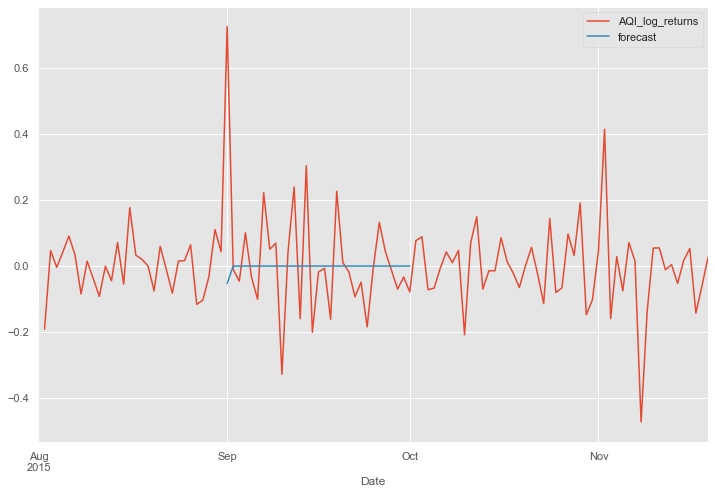

In [102]:
dfAQI_log_returns['forecast']=result9.predict(start=30,end=60,dynamic=True)
dfAQI_log_returns[['AQI_log_returns','forecast']].plot(figsize=(12,8))

<h3>  B1.2 AUTO-ARIMA 

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

- start_p :  the order (or number of time lags) of the auto-regressive (“AR”) model. Must be a positive integer.

- d : The order of first-differencing.

- start_q : the order of the moving-average (“MA”) model. Must be a positive integer.

- max_p : The maximum value of p, inclusive. 

- max_d : The maximum value of d, or the maximum number of non-seasonal differences. 
    
- max_q : The maximum value of q, inclusive. Must be a positive integer greater than start_q.

- start_P :  the order of the auto-regressive portion of the seasonal model.

- D : The order of the seasonal differencing. 

- m : The period for seasonal differencing, m refers to the number of periods in each season. 

- seasonal :Whether to fit a seasonal ARIMA. 

In [103]:
dfAQI2.head()

Date
2015-08-01    16.351424
2015-08-02    13.504069
2015-08-03    14.150691
2015-08-04    14.092559
2015-08-05    14.696507
Freq: D, Name: AQI, dtype: float64

In [104]:
# fit stepwise autoARIMA with seasonality (sarima)
# we use 'auto_arima' function from pdmarima package (abreviated pm)
# best fitted model based on AIC
#d=1 --> diferenciamos 1x
#considera-se que a série não tem sazonalidade
# p=numero de lags da parte sazional

stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=6, max_q=6,  
start_P=0, seasonal=False, d=1, D=1, trace=True, error_action='ignore', # don't want to know if an order does not work
suppress_warnings=True, # don't want convergence warnings
stepwise=True) # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=462.731, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=467.846, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=463.673, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=461.804, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=465.957, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=462.845, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=462.267, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=460.106, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=461.151, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=461.248, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=461.865, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=460.618, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.408 seconds


O melhor modelo é um SARIMA com :

Parte da Tendência: 
 - 0 lags da parte autoregressiva

 - Diferenciada e integrada uma vez para tornar a serie estacionaria

 - 1 lag no termo erro da parte media movel


Na parte sazonal: 

- 0 lags na parte autoregressiva, 

- 0x Diferenciada e integrada, 

- 0 na parte media movel. 

In [105]:
# best fitted model output
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   88
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -228.053
Date:                Tue, 22 Jun 2021   AIC                            460.106
Time:                        11:42:07   BIC                            465.038
Sample:                             0   HQIC                           462.092
                                 - 88                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3440      0.080     -4.286      0.000      -0.501      -0.187
sigma2        11.0596      0.821     13.476      0.000       9.451      12.668
===================================================================================
Ljung-Box (Q):                       54.43   Jarque-Bera (JB):               161.75
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
# all variables are statisticaly significant
# residuals are independent (we do not reject Ljung-Box H0: residuals are independent)
# residuals are heteroskedastic or variance is not constant (we  reject H0: variance is constant)
# residuals are not Gaussian (we reject Jarque-Bera H0: normal distribution)

In [107]:
#Analise dos testes da parte residual
#Ljung-Box test tem como H0 residuos independentes, o p-value=0.06>0.05 --> os residuos sao independentes
#heteroskedastic: tem como H0 variancia constante, o p-value<0.05 --> não se rejeita a hipotese nula


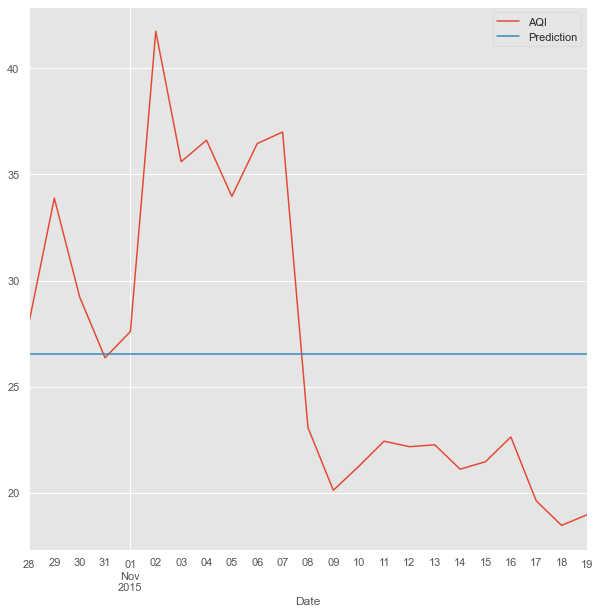

In [108]:
# since residuals are independent -> Box_Jenkins -> we can do some forecast
# forecast (out-of-sample) 23 future values (the same as AQI_test length) by using best fitted model on the train set : that is ARIMA(0,1,1)(2,1,0)[7]   intercept

future_forecast = stepwise_fit.predict(n_periods=len(test_data))

# join the forecasted value and the AQI_test values in the same dataframe and plot both

future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])
pd.concat([test_data,future_forecast],axis=1).plot()
plt.show()

Text(0.5, 1.0, 'Grafico Auto-arima AQI vs forecast')

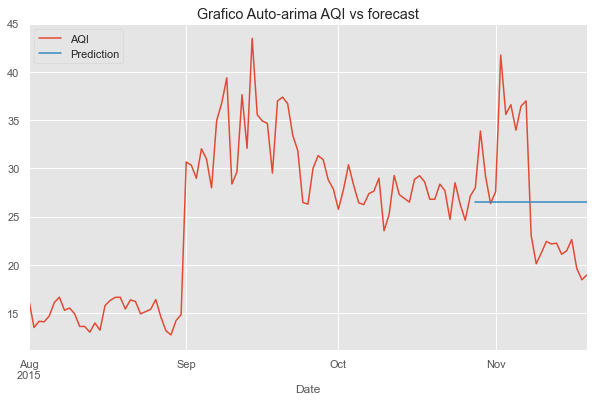

In [109]:
# plot original AQI time series and the forecast (last x values)
plt.rcParams["figure.figsize"] = (10,6)
pd.concat([dfAQI['AQI'],future_forecast],axis=1).plot()
plt.title("Grafico Auto-arima AQI vs forecast")
#plt.rcParams["figure.figsize"] = (10,6)


In [110]:
# forecast performance metrics
model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
print(f"Root mean squared error: {mean_squared_error(test_data, forecasts, squared=False)}")
print(f"SMAPE: {smape(test_data, forecasts)}")

Mean squared error: 48.715241160336035
Root mean squared error: 6.979630445828492
SMAPE: 22.326931030344742


In [111]:
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data - forecasts) / test_data)) * 100

print('The Mean Absolute Percentage Error for the forecast of the 23 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of the 23 is 22.69%


In [112]:
dfAQI2.head()

Date
2015-08-01    16.351424
2015-08-02    13.504069
2015-08-03    14.150691
2015-08-04    14.092559
2015-08-05    14.696507
Freq: D, Name: AQI, dtype: float64

<b> Previsao para os ultimos 5 dias do dataset

In [113]:
test_data.tail()

Date
2015-11-15    21.457219
2015-11-16    22.624194
2015-11-17    19.612392
2015-11-18    18.455226
2015-11-19    18.954000
Freq: D, Name: AQI, dtype: float64

In [114]:
# forecast performance metrics
model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(test_data[-5:], forecasts[-5:])}")
print(f"Root mean squared error: {mean_squared_error(test_data[-5:], forecasts[-5:], squared=False)}")
print(f"SMAPE: {smape(test_data[-5:], forecasts[-5:])}")

# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data[-5:] - forecasts[-5:]) / test_data[-5:])) * 100

print('The Mean Absolute Percentage Error for the forecast of the 23 is {:.2f}%'.format(MAPE))

Mean squared error: 42.10478650503264
Root mean squared error: 6.488820116556834
SMAPE: 27.19241840331828
The Mean Absolute Percentage Error for the forecast of the 23 is 31.91%


<h3>  B1.3 SARIMAX from statsmodels

In [115]:
# Let's fit this model
# Com base no melhor modelo que foi obtido pelo auto-arima
#ARIMA(0,1,1)(0,0,0)[0]  

mod = SARIMAX(train_data,order=(0,1,1),seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)

results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                   88
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -223.431
Date:                Tue, 22 Jun 2021   AIC                            450.862
Time:                        11:42:08   BIC                            455.748
Sample:                    08-01-2015   HQIC                           452.827
                         - 10-27-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3447      0.081     -4.232      0.000      -0.504      -0.185
sigma2        11.2364      0.848     13.253      0.000       9.575      12.898
===================================================================================
Ljung-Box (Q):                       53.67   Jarque-Bera (JB):               151.53
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               3.49   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
# all variables are statisticaly significant
# residuals are independent (we do not reject Ljung-Box H0: residuals are independent)
# residuals are heteroskedastic or variance is not constant (we reject H0: variance is constant)
# residuals are not Gaussian (we reject Jarque-Bera H0: normal distribution)

In [117]:
#Analise dos testes da parte residual
#Ljung-Box test tem como H0 residuos independentes, o p-value=0,07>0.05 --> os residuos sao independentes
#heteroskedastic: tem como H0 variancia constante, o p-value=0.00<0.05 --> rejeita-se a hipotese nula

In [118]:
# AIC, BIC e HQIC --> quanto menores, melhor se ajustou o modelo. O ideal é convergirem para menos infinito
#Log likelihood ---> Quanto maior nmelhor o modelo se ajustou

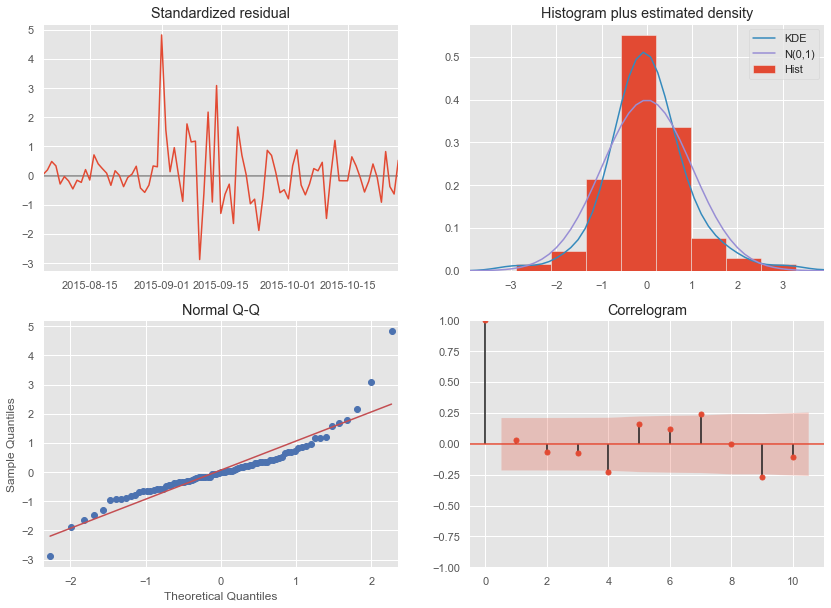

In [119]:
results.plot_diagnostics(figsize=(14, 10))
plt.show()

In [120]:
# 1ºGRÁFICO: variancia não é constante
# 2ºGRÁFICO: ELOPTOCURTICA
# 3ºGRÁFICO: não é totalmente tangente, caudas afastadas
# 4ªGRÁFICO: não há correlacao, não há um padrao certo

In [121]:
# static prediction
pred0 = results.get_prediction(start='2015-08-01', dynamic=False)
pred0_ci = pred0.conf_int()
pred0_ci

lower AQI    upper AQI
Date                                
2015-08-01 -2771.807649  2771.807649
2015-08-02 -1943.623572  1976.326420
2015-08-03     6.554674    20.453487
2015-08-04     7.340157    20.562754
2015-08-05     7.469697    20.619345
...                 ...          ...
2015-10-23    21.198612    34.338529
2015-10-24    19.191260    32.331177
2015-10-25    21.000723    34.140640
2015-10-26    20.173686    33.313603
2015-10-27    18.785166    31.925083

[88 rows x 2 columns]

In [122]:
# dynamic prediction
pred1 = results.get_prediction(start='2015-08-01', dynamic=True)
pred1_ci = pred1.conf_int()
pred1_ci

lower AQI    upper AQI
Date                                
2015-08-01 -2771.807649  2771.807649
2015-08-02 -3394.763560  3394.763560
2015-08-03 -3394.766289  3394.766289
2015-08-04 -3394.769019  3394.769019
2015-08-05 -3394.771749  3394.771749
...                 ...          ...
2015-10-23 -3394.987385  3394.987385
2015-10-24 -3394.990115  3394.990115
2015-10-25 -3394.992844  3394.992844
2015-10-26 -3394.995574  3394.995574
2015-10-27 -3394.998303  3394.998303

[88 rows x 2 columns]

<b>Valores para comparar com o modelo auto-arima

In [123]:
# out-of-sample prediction (forecast) based on sarimax model
#pred2 = results.get_forecast('2016-01-01 00:00:00')
pred2= results.get_forecast('2015-11-19') #para comparar com o modelo auto-arima
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2015-10-28':'2015-11-19'])

2015-10-28    26.514804
2015-10-29    26.514804
2015-10-30    26.514804
2015-10-31    26.514804
2015-11-01    26.514804
2015-11-02    26.514804
2015-11-03    26.514804
2015-11-04    26.514804
2015-11-05    26.514804
2015-11-06    26.514804
2015-11-07    26.514804
2015-11-08    26.514804
2015-11-09    26.514804
2015-11-10    26.514804
2015-11-11    26.514804
2015-11-12    26.514804
2015-11-13    26.514804
2015-11-14    26.514804
2015-11-15    26.514804
2015-11-16    26.514804
2015-11-17    26.514804
2015-11-18    26.514804
2015-11-19    26.514804
Freq: D, dtype: float64


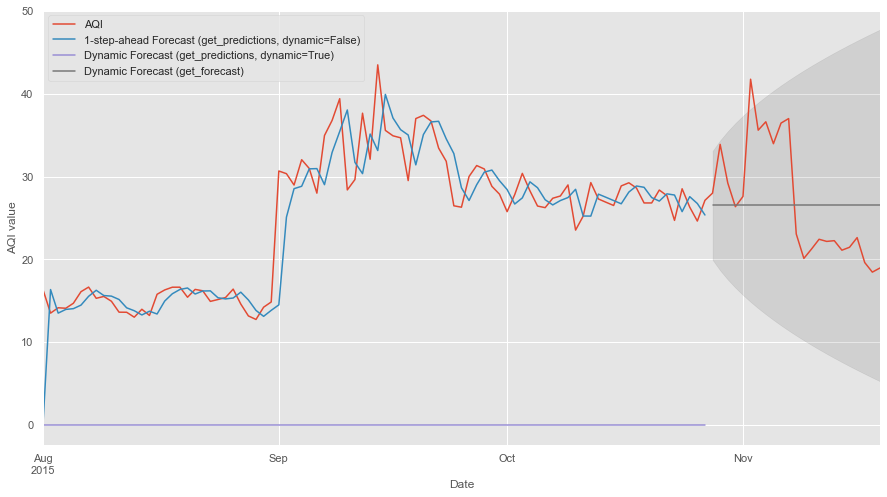

In [124]:
# plot all predictions
ax = dfAQI2.plot(figsize=(15, 8))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('AQI value')
plt.xlabel('Date')
#plt.title("Grafico SARIMAX AQI vs forecast")
plt.legend()
plt.show()


In [125]:
prediction = pred2.predicted_mean['2015-10-28':'2015-11-19'].values
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data.values - prediction) / test_data.values)) * 100

print('The Mean Absolute Percentage Error for the AQI forecast from the last 23 results is {:.2f}%'.format(MAPE))

print(f"Mean squared error: {mean_squared_error(test_data, prediction)}")
print(f"Root mean squared error: {mean_squared_error(test_data, prediction, squared=False)}")
print(f"SMAPE: {smape(test_data, prediction)}")

The Mean Absolute Percentage Error for the AQI forecast from the last 23 results is 22.69%
Mean squared error: 48.715826774757666
Root mean squared error: 6.979672397380672
SMAPE: 22.326600849274882


<b> Forecast para uma data posterior ao dataset

In [126]:
# out-of-sample prediction (forecast) based on sarimax model
#pred2 = results.get_forecast('2016-01-01 00:00:00')
pred2= results.get_forecast('2016-11-19') #para comparar com o modelo auto-arima
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2015-10-28':'2015-11-19'])

2015-10-28    26.514804
2015-10-29    26.514804
2015-10-30    26.514804
2015-10-31    26.514804
2015-11-01    26.514804
2015-11-02    26.514804
2015-11-03    26.514804
2015-11-04    26.514804
2015-11-05    26.514804
2015-11-06    26.514804
2015-11-07    26.514804
2015-11-08    26.514804
2015-11-09    26.514804
2015-11-10    26.514804
2015-11-11    26.514804
2015-11-12    26.514804
2015-11-13    26.514804
2015-11-14    26.514804
2015-11-15    26.514804
2015-11-16    26.514804
2015-11-17    26.514804
2015-11-18    26.514804
2015-11-19    26.514804
Freq: D, dtype: float64


In [127]:
prediction = pred2.predicted_mean['2015-10-28':'2015-11-19'].values
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data.values - prediction) / test_data.values)) * 100

print('The Mean Absolute Percentage Error for the AQI forecast from the last 23 results is {:.2f}%'.format(MAPE))

print(f"Mean squared error: {mean_squared_error(test_data, prediction)}")
print(f"Root mean squared error: {mean_squared_error(test_data, prediction, squared=False)}")
print(f"SMAPE: {smape(test_data, prediction)}")

The Mean Absolute Percentage Error for the AQI forecast from the last 23 results is 22.69%
Mean squared error: 48.715826774757666
Root mean squared error: 6.979672397380672
SMAPE: 22.326600849274882


<b> Previsao para os ultimos 5 dias do dataset

In [128]:
test_data.tail()

Date
2015-11-15    21.457219
2015-11-16    22.624194
2015-11-17    19.612392
2015-11-18    18.455226
2015-11-19    18.954000
Freq: D, Name: AQI, dtype: float64

In [129]:
prediction = pred2.predicted_mean['2015-11-15':'2015-11-19'].values
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data[-5:] - prediction) / test_data[-5:])) * 100

print('The Mean Absolute Percentage Error for the AQI forecast from the last 23 results is {:.2f}%'.format(MAPE))

print(f"Mean squared error: {mean_squared_error(test_data[-5:], prediction)}")
print(f"Root mean squared error: {mean_squared_error(test_data[-5:], prediction, squared=False)}")
print(f"SMAPE: {smape(test_data[-5:], prediction)}")

The Mean Absolute Percentage Error for the AQI forecast from the last 23 results is 31.90%
Mean squared error: 42.09636912197047
Root mean squared error: 6.48817147754053
SMAPE: 27.189946933667187


<h2> B2. ARCH

Autoregressive Conditional Heteroskedasticity (**ARCH**) and Generalised Autoregressive Conditional Heteroskedasticity (**GARCH**) model overcomes the volatility difficulty.
Models can also be systematically assembled from the three model components:

* A mean model (`arch.mean`)
    * Zero mean (`ZeroMean`) - useful if using residuals from a model estimated separately
    * Constant mean (`ConstantMean`) - common for most liquid financial assets
    * Autoregressive (`ARX`) with optional exogenous regressors
    * Heterogeneous (`HARX`) autoregression with optional exogenous regressors
    * Exogenous regressors only (`LS`)
* A volatility process (`arch.volatility`)
    * ARCH (`ARCH`)
    * GARCH (`GARCH`)
    * GJR-GARCH (`GARCH` using `o` argument) 
    * TARCH/ZARCH (`GARCH` using `power` argument set to `1`)
    * Power GARCH and Asymmetric Power GARCH (`GARCH` using `power`)
    * Exponentially Weighted Moving Average Variance with estimated coefficient (`EWMAVariance`)
    * Heterogeneous ARCH (`HARCH`)
    * Parameterless Models
        * Exponentially Weighted Moving Average Variance, known as RiskMetrics (`EWMAVariance`)
        * Weighted averages of EWMAs, known as the RiskMetrics 2006 methodology (`RiskMetrics2006`)
* A distribution (`arch.distribution`)
    * Normal (`Normal`)
    * Standardized Students's T (`StudentsT`)

<b>Calculo dos retornos

In [130]:
AQI_log_returns = np.log(dfAQI2).diff().dropna()

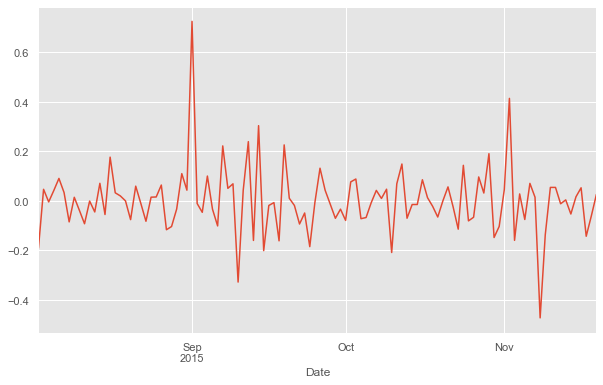

In [131]:
AQI_log_returns.plot()

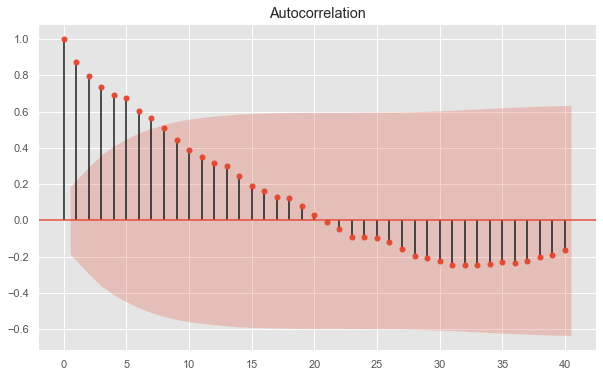

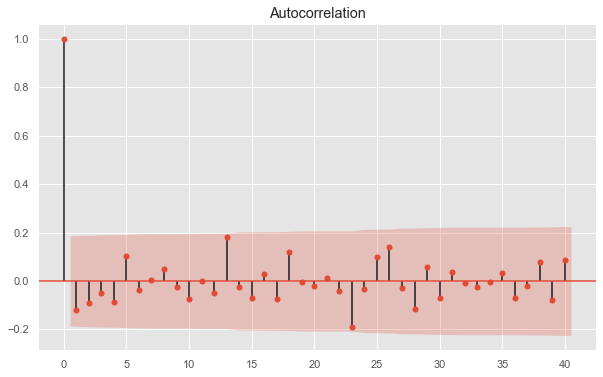

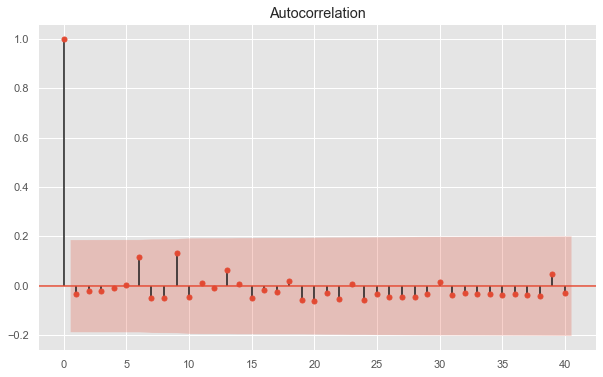

In [132]:
# Verificacao da autocorrelacao
plot_acf(dfAQI2, lags=40)
plot_acf(AQI_log_returns, lags=40)

ret2=AQI_log_returns*AQI_log_returns
plot_acf(ret2, lags=40)
plt.show()

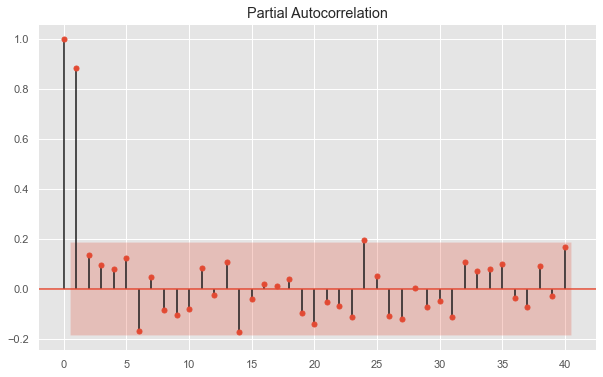

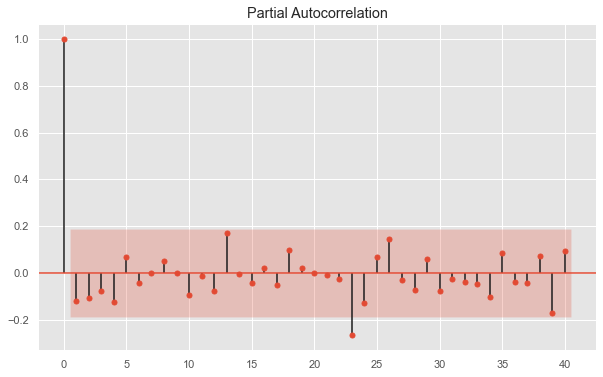

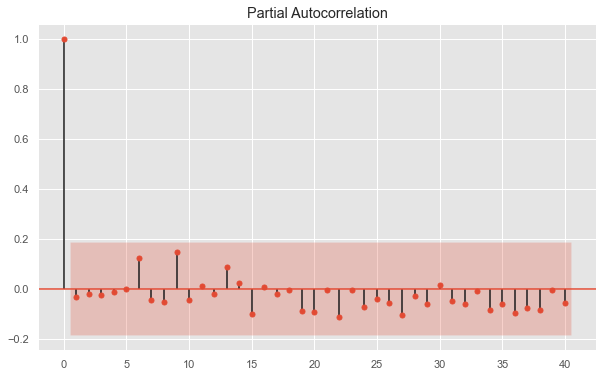

In [133]:
# Verificacao da autocorrelacao parcial
plot_pacf(dfAQI2, lags=40)
plot_pacf(AQI_log_returns, lags=40)

ret2=AQI_log_returns*AQI_log_returns
plot_pacf(ret2, lags=40)
plt.show()

In [134]:
# A analise  dos graficos de autocorrelacao dos retornos e dos retornos ao quadrado sao tipicos de ruido branco, o primeiro elemento é 1 e os restante são 0. 

<h3> a) Divisao conjunto de treino e teste

In [135]:
train_datart = AQI_log_returns['2015-08-01':'2015-10-27']
test_datart = AQI_log_returns['2015-10-28':'2015-11-19']

<h3>b) Parameter Estimation for ARMA Model

In [136]:
arima_fin = pmdarima.auto_arima(train_datart)

#arima_fin= stepwise_fit
print(arima_fin)

 ARIMA(0,0,0)(0,0,0)[0]          


In [137]:
#An ARIMA(0,0,0) model with zero mean is white noise, so it means that the errors are uncorrelated across time

<h1> C. Estudo da estacionaridade de todas as variáveis

Uma série temporal estacionária é aquela cujas propriedades não dependem do tempo em que a série é observada. Assim, as séries temporais com tendências, ou com sazonalidade, não são estacionárias. 

Abaixo, através do teste ADF (Teste de Dickey-Fuller aumentado) é possível observar que as variáveis AQI é estacionária,ou seja, não tem tendência ou sazonalidade. 

**Critério:** 

P-value > 0,05: os dados têm raiz unitária e não são estacionários. <br>
p-value <= 0,05: os dados não têm raiz unitária e são estacionários.

In [138]:
#Agregar as variáveis por dia
dfagg=df.resample('1D').mean()

In [139]:
#Eliminar a coluna do Ozono e do WindOrigin_new
dfagg=dfagg.drop(columns="Ozone")
dfagg=dfagg.drop(columns="WindOrigin_new")

In [140]:
dfagg.head()

SO2  Toluene  WindDirection  WindSpeed        AQI
Date                                                         
2015-08-01  2.5      2.5     195.788194   8.656250  16.351424
2015-08-02  2.5      2.5     190.017361   7.381944  13.504069
2015-08-03  2.5      2.5     211.517361   7.784722  14.150691
2015-08-04  2.5      2.5     208.697917   7.076389  14.092559
2015-08-05  2.5      2.5     165.055556   6.045139  14.696507

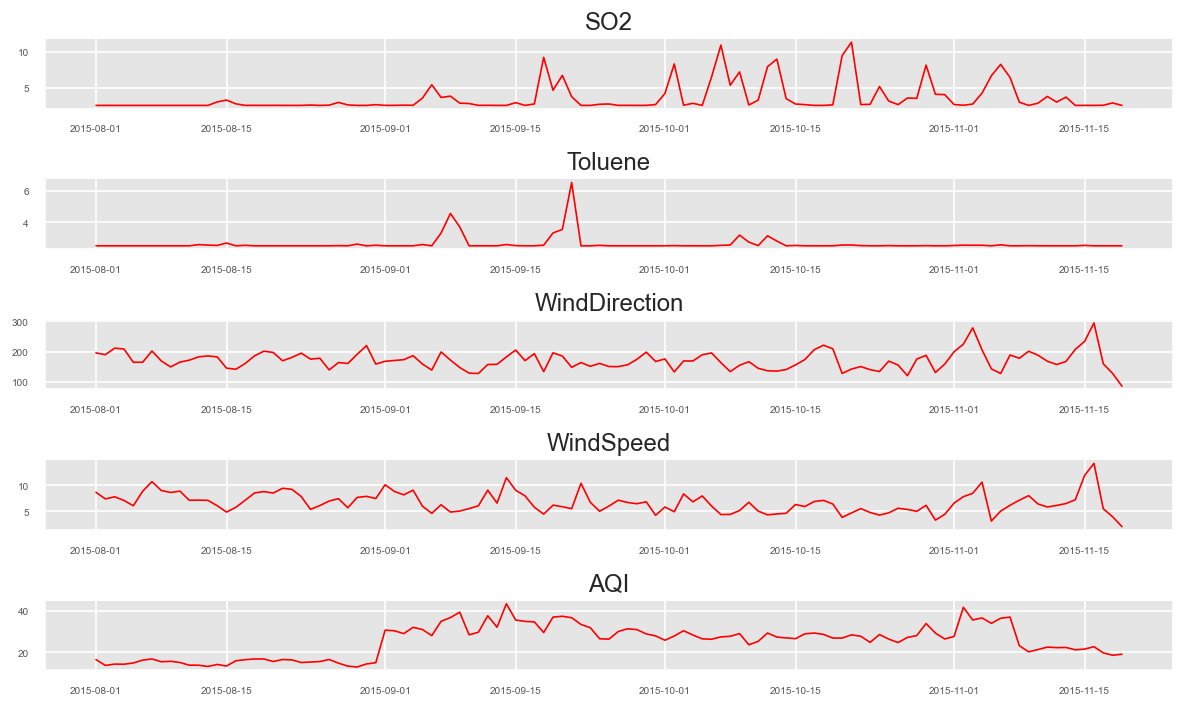

In [141]:
# Plot time series
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dfagg[dfagg.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dfagg.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [142]:
# Using plotly.express
fig1 = px.line(dfagg["SO2"])
fig2 =px.line(dfagg["Toluene"])
fig3 =px.line(dfagg["WindDirection"])
fig4 =px.line(dfagg["WindSpeed"])
fig5 =px.line(dfagg["AQI"])
#fig1.show()
#fig2.show()
#fig3.show()
#fig4.show()
#fig5.show()

In [143]:
fig = px.line(dfagg, y=dfagg.columns)
fig.show()

In [144]:
#adfuller
t1=adfuller(dfagg.SO2, regression='c', autolag='AIC')
print("p-value =", t1[1])

if t1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

# unit root test in first difference
test=adfuller(dfagg['SO2'].diff().dropna(),autolag='AIC')
print("p-value =", test[1])

p-value = 6.04697550728214e-09
p-value = 3.1519966006509696e-05


In [145]:
#adfuller
t1=adfuller(dfagg.Toluene, regression='c', autolag='AIC')
print("p-value =", t1[1])

if t1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

# unit root test in first difference
test=adfuller(dfagg['Toluene'].diff().dropna(),autolag='AIC')
print("p-value =", test[1])

p-value = 1.320341497235036e-10
p-value = 8.216244505051247e-09


In [146]:
#adfuller
t1=adfuller(dfagg.WindDirection, regression='c', autolag='AIC')
print("p-value =", t1[1])

if t1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

# unit root test in first difference
test=adfuller(dfagg['WindDirection'].diff().dropna(),autolag='AIC')
print("p-value =", test[1])

p-value = 2.9106494680770412e-09
p-value = 2.2934871826358922e-06


In [147]:
#adfuller
t1=adfuller(dfagg.WindSpeed, regression='c', autolag='AIC')
print("p-value =", t1[1])

if t1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

# unit root test in first difference
test=adfuller(dfagg['WindSpeed'].diff().dropna(),autolag='AIC')
print("p-value =", test[1])

p-value = 0.37670464550560856
We do not reject the H0: non-stationary time series <-> we have a unit root
p-value = 4.057153624872527e-12


In [148]:
#adfuller
t1=adfuller(dfagg.AQI, regression='c', autolag='AIC')
print("p-value =", t1[1])

if t1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

# unit root test in first difference
test=adfuller(dfagg["AQI"].diff().dropna(),autolag='AIC')
print("p-value =", test[1])

p-value = 0.16652953740524234
We do not reject the H0: non-stationary time series <-> we have a unit root
p-value = 1.8921435583641965e-15


#### Lag Selection 

In [149]:
lag_order5 = select_order(data=dfagg, maxlags=10, deterministic="c")
lag_order5.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [150]:
print(lag_order5)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 0, BIC -> 0, FPE -> 0, HQIC -> 0>


#### Cointegration Rank

In [151]:
rank_test = select_coint_rank(dfagg, 0, 0, method="trace", signif=0.05)
rank_test.rank

5

In [152]:
rank_test.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

<h1> D. Modelos Estocásticos de Séries Temporais Multivariados

<h2> D1. Modelo VAR

#### Granger Causality

In [153]:
# Granger causality (all in one)

maxlag=20
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(dfagg, variables = dfagg.columns)

SO2_x  Toluene_x  WindDirection_x  WindSpeed_x   AQI_x
SO2_y            1.0000     0.0000           0.0013       0.0001  0.0047
Toluene_y        0.0003     1.0000           0.0097       0.0000  0.0000
WindDirection_y  0.0531     0.1635           1.0000       0.0028  0.0901
WindSpeed_y      0.0135     0.0780           0.0004       1.0000  0.0000
AQI_y            0.2811     0.4066           0.0330       0.0296  1.0000

In [154]:
model = VAR(dfagg)

In [155]:
model_var = model.fit(10)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Jun, 2021
Time:                     11:42:16
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    16.2462
Nobs:                     101.000    HQIC:                   12.3166
Log likelihood:          -948.571    FPE:                    25680.5
AIC:                      9.64371    Det(Omega_mle):         3326.54
--------------------------------------------------------------------
Results for equation SO2
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     9.935297         6.770254            1.467           0.142
L1.SO2                    0.393841         0.160060            2.461           0.014
L1.Toluene                0.309374         0.6

#### Diagnostics

In [156]:
# check if residuals are normally distributed - we do not reject normality (p-value>0.05)
norm_test = model_var.test_normality()
norm_test.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [157]:
# check for residuals serial correlation - we do not reject independence (p-value>0.05)
white_test = model_var.test_whiteness(nlags=20, adjusted=True)
white_test.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [158]:
# ARCH effect
test_arch = het_arch(model_var.resid.iloc[:,0], nlags=5)

print('ARCH test for heteroskedasticity:')
print(f'Lagrange mulitplier p-value: {test_arch[1]}')
print(f'F test p-value: {test_arch[3]}')

ARCH test for heteroskedasticity:
Lagrange mulitplier p-value: 0.11403556770077793
F test p-value: 0.11407980925428611


In [159]:
# ARCH effect
test_arch = het_arch(model_var.resid.iloc[:,1], nlags=5)

print('ARCH test for heteroskedasticity:')
print(f'Lagrange mulitplier p-value: {test_arch[1]}')
print(f'F test p-value: {test_arch[3]}')

ARCH test for heteroskedasticity:
Lagrange mulitplier p-value: 0.9964463556362384
F test p-value: 0.9968163973583387


In [160]:
# ARCH effect
test_arch = het_arch(model_var.resid.iloc[:,2], nlags=5)

print('ARCH test for heteroskedasticity:')
print(f'Lagrange mulitplier p-value: {test_arch[1]}')
print(f'F test p-value: {test_arch[3]}')

ARCH test for heteroskedasticity:
Lagrange mulitplier p-value: 0.4602199245653791
F test p-value: 0.4744142058498616


In [161]:
# ARCH effect
test_arch = het_arch(model_var.resid.iloc[:,3], nlags=5)

print('ARCH test for heteroskedasticity:')
print(f'Lagrange mulitplier p-value: {test_arch[1]}')
print(f'F test p-value: {test_arch[3]}')

ARCH test for heteroskedasticity:
Lagrange mulitplier p-value: 0.6994928159192172
F test p-value: 0.7142098969078619


In [162]:
# ARCH effect
test_arch = het_arch(model_var.resid.iloc[:,4], nlags=5)

print('ARCH test for heteroskedasticity:')
print(f'Lagrange mulitplier p-value: {test_arch[1]}')
print(f'F test p-value: {test_arch[3]}')

ARCH test for heteroskedasticity:
Lagrange mulitplier p-value: 0.9296273449861163
F test p-value: 0.935303211775726


## Forecasting

Previsão para 5 dias

In [163]:
#Divisão em conjunto de treino e teste
train_data = dfagg['2015-08-01':'2015-10-27']
test_data = dfagg['2015-10-28':'2015-11-19']

In [164]:
model = VAR(train_data)

In [165]:
results = model.fit(10)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Jun, 2021
Time:                     11:42:17
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    14.8227
Nobs:                     78.0000    HQIC:                   10.2023
Log likelihood:          -575.990    FPE:                    4444.66
AIC:                      7.11804    Det(Omega_mle):         359.222
--------------------------------------------------------------------
Results for equation SO2
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                   -16.478773        10.880874           -1.514           0.130
L1.SO2                    0.588876         0.229229            2.569           0.010
L1.Toluene               -1.785717         0.7

In [166]:
lagged_values=train_data.values[-10:]

In [167]:
z = results.forecast(y=lagged_values, steps=5)

In [168]:
df_forecast=pd.DataFrame(data=z, columns=['SO2','Toluene','WindDirection','WindSpeed','AQI'])

In [169]:
df_forecast

SO2   Toluene  WindDirection  WindSpeed        AQI
0  8.456603  1.842621     144.626055   5.480622  31.180112
1  6.369471  2.256081     201.835465   6.211327  30.954735
2 -0.715846  2.706520     217.107362   7.945289  28.985142
3  4.658163  2.849131     172.101194   7.706057  34.523779
4  8.558745  2.004226     161.142652   6.393521  37.134672

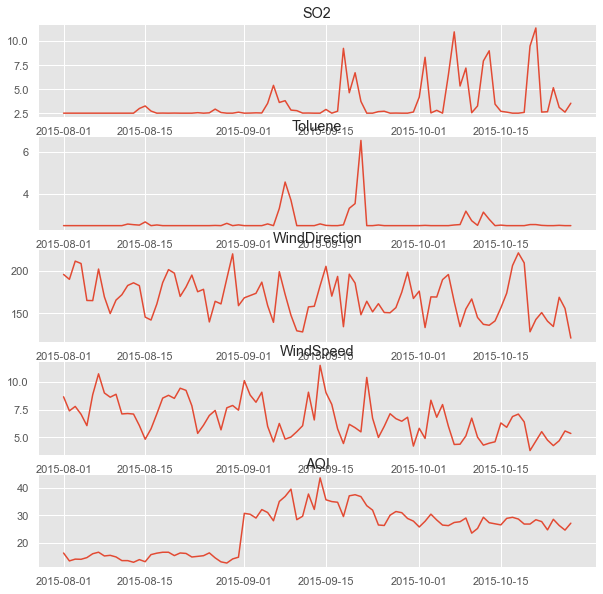

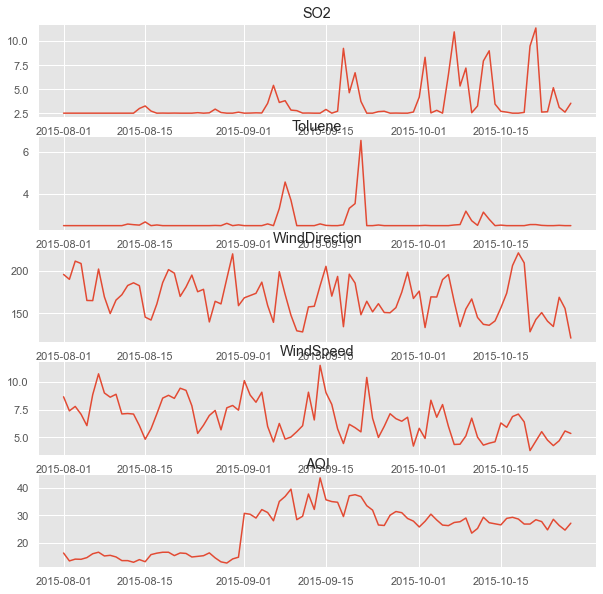

In [170]:
results.plot()

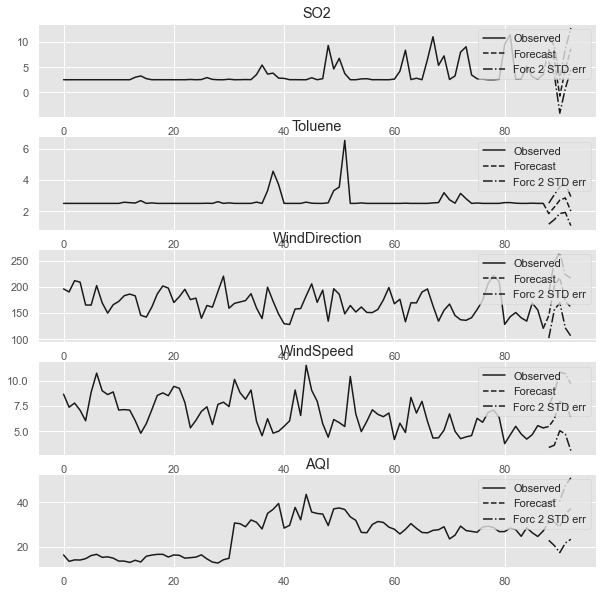

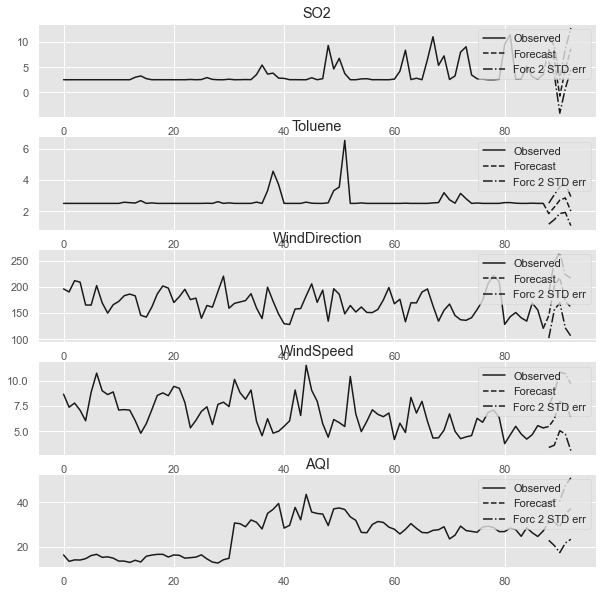

In [171]:
results.plot_forecast(5)

In [172]:
test_range=test_data

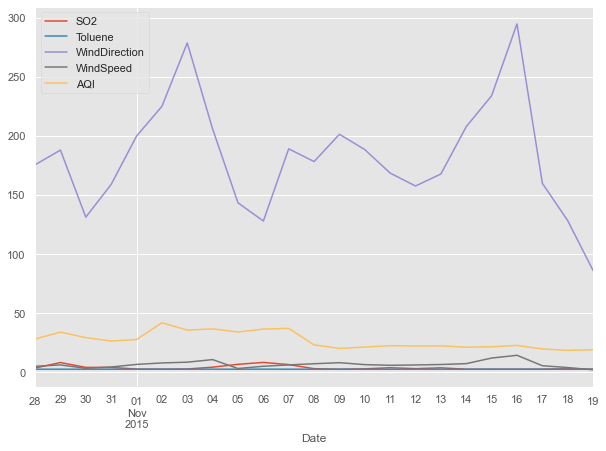

In [173]:
test_range.plot(figsize=(10,7))

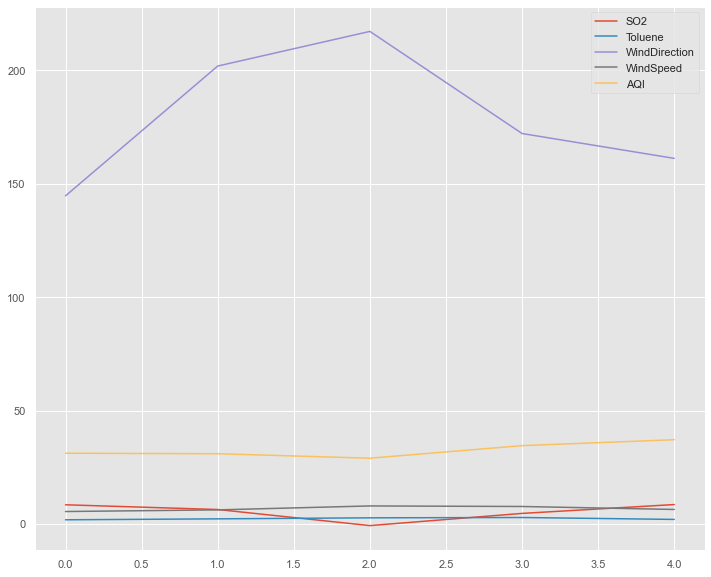

In [174]:
df_forecast.plot(figsize=(12,10))

In [175]:
mse = mean_squared_error(test_data.AQI[-5:], df_forecast.AQI)
rmse = sqrt(mse)

print(rmse)

12.965463487829892


In [176]:
df_forecast

SO2   Toluene  WindDirection  WindSpeed        AQI
0  8.456603  1.842621     144.626055   5.480622  31.180112
1  6.369471  2.256081     201.835465   6.211327  30.954735
2 -0.715846  2.706520     217.107362   7.945289  28.985142
3  4.658163  2.849131     172.101194   7.706057  34.523779
4  8.558745  2.004226     161.142652   6.393521  37.134672

In [177]:
test_data[-5:]

SO2   Toluene  WindDirection  WindSpeed        AQI
Date                                                               
2015-11-15  2.500000  2.526771     233.836806  11.940972  21.457219
2015-11-16  2.500000  2.500000     294.607639  14.274306  22.624194
2015-11-17  2.519792  2.500000     159.798611   5.461806  19.612392
2015-11-18  2.847917  2.500000     128.190972   3.909722  18.455226
2015-11-19  2.500000  2.500000      86.000000   2.000000  18.954000

Previsão para o Conjunto de Teste inteiro

In [178]:
z2 = results.forecast(y=lagged_values, steps=23)

In [179]:
df_forecast2=pd.DataFrame(data=z2, columns=['SO2','Toluene','WindDirection','WindSpeed','AQI'])

In [180]:
df_forecast2

SO2   Toluene  WindDirection  WindSpeed        AQI
0    8.456603  1.842621     144.626055   5.480622  31.180112
1    6.369471  2.256081     201.835465   6.211327  30.954735
2   -0.715846  2.706520     217.107362   7.945289  28.985142
3    4.658163  2.849131     172.101194   7.706057  34.523779
4    8.558745  2.004226     161.142652   6.393521  37.134672
5    6.981398  2.775461     170.361705   4.751630  34.807224
6    5.283353  3.441032     175.898425   5.948512  34.373471
7    5.945434  3.106561     133.815866   4.587263  34.255493
8    8.777131  3.005418     120.137212   1.975894  33.992794
9    6.021241  3.090213     158.221575   4.908551  31.037778
10  -0.010579  3.343034     160.503664   5.312008  30.774808
11   2.875407  2.856588     132.826670   4.573941  33.303320
12   7.326302  2.502281     132.627358   3.519456  32.212920
13   3.560984  2.465803     175.760846   6.514997  30.770106
14   1.740745  2.315233     170.939799   7.495218  31.792739
15   3.508619  1.853525     150.864614   6.482766  33.543574
16   5.493385  2.123332     176.817265   5.609486  33.796678
17   6.058682  2.388063     211.260733   7.614466  33.084256
18   1.834834  2.751026     197.226240   6.968902  34.501282
19   7.773220  2.738554     135.981255   3.511384  35.285836
20  11.406132  2.912861     136.698480   3.647126  34.368413
21   5.160210  2.899337     171.601100   5.300627  31.308020
22   2.581363  3.218929     156.138680   5.008708  31.558394

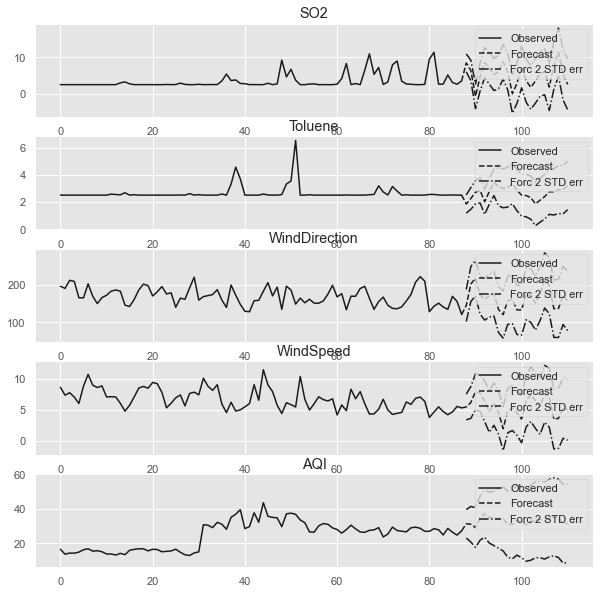

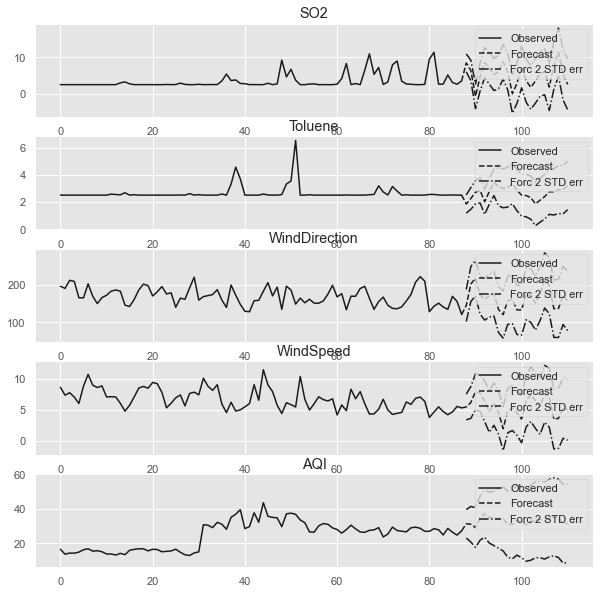

In [181]:
results.plot_forecast(23)

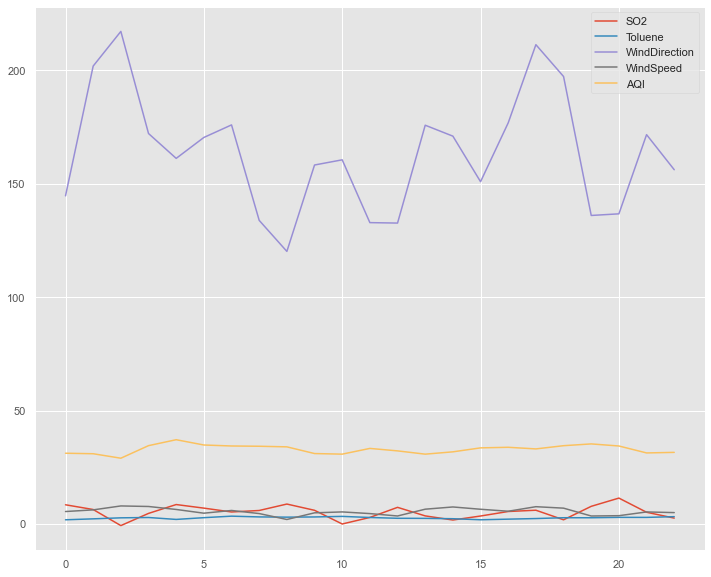

In [182]:
df_forecast2.plot(figsize=(12,10))

In [183]:
mse = mean_squared_error(test_data.AQI, df_forecast2.AQI)
rmse = sqrt(mse)

print(rmse)

9.344246294477907


<h1> E. Deep Learning

In [185]:
dfready1 = dfready
AQI = dfready1["AQI"]
AQI = AQI.to_frame()

### Modelo 1 - Sem remoção dos outliers e com Rolling Windows

In [186]:
# Cria regra adicional de aprendizagem através das rolling window. Ou seja, quantos intervalos de 
#cinco minutos são importante para prever o próximo valor. 
seq_length = 12

minMax = MinMaxScaler()
X = minMax.fit_transform(AQI)

X = X.squeeze() # Aplica-se a transoformação

x = []
y = []
for i in range(len(AQI) - seq_length):
    x.append(X[i: i+(seq_length)-1])
    y.append(X[i+(seq_length)-1])
x = np.array(x)
y = np.array(y)

In [187]:
# Verifica Dimensão

x_train, x_test, y_train, y_test= train_test_split(x, y)
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(23629, 11)
(7877, 11)
(7877,)
(23629,)


In [188]:
# reshape data
x_train = x_train.reshape(-1, seq_length-1,1)
x_test = x_test.reshape(-1, seq_length-1,1)
x_train.shape[0]

23629

In [189]:
#Define arquitetura da rede neuronal artificial
input = Input((seq_length-1, 1))
X = LSTM(150, recurrent_dropout= 0.3)(input) #150 neurónios e #30% de dropout para evitar o overfitting
X= LSTM(150, recurrent_dropout= 0.3)(input) #50 neurónios e #30% de dropout para evitar o overfitting
X= LSTM(100, recurrent_dropout= 0.2)(input)#100 neurónios e #20% de dropout para evitar o overfitting
X = Dense(1)(X) #O output é apenas o 1, ou seja, o AQI e por isso a camada densa é definida como 1 
model = Model(input, X)
model.compile(loss='mse', optimizer= "adam")


In [190]:
# Define dependencia da taxa de aprendizagem
def reduce(epoch, lr):
    if epoch%10 == 0:
        return lr
    return lr
scheduler = LearningRateScheduler(reduce)

In [191]:
#Faz fit do modelo e define o conjunto de validação de 20%
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)
#não utiliza-se as batchs já que a rolling windows foi definido

Epoch 1/10
591/591 [==============================] - 8s 11ms/step - loss: 5.6511e-04 - val_loss: 2.5988e-04
Epoch 2/10
591/591 [==============================] - 6s 10ms/step - loss: 2.0359e-04 - val_loss: 1.7817e-04
Epoch 3/10
591/591 [==============================] - 6s 11ms/step - loss: 1.5558e-04 - val_loss: 1.6675e-04
Epoch 4/10
591/591 [==============================] - 6s 11ms/step - loss: 1.4043e-04 - val_loss: 1.4487e-04
Epoch 5/10
591/591 [==============================] - 6s 10ms/step - loss: 1.3133e-04 - val_loss: 1.3503e-04
Epoch 6/10
591/591 [==============================] - 6s 11ms/step - loss: 1.2721e-04 - val_loss: 1.2906e-04
Epoch 7/10
591/591 [==============================] - 6s 10ms/step - loss: 1.2183e-04 - val_loss: 1.2828e-04
Epoch 8/10
591/591 [==============================] - 6s 11ms/step - loss: 1.2154e-04 - val_loss: 1.2408e-04
Epoch 9/10
591/591 [==============================] - 6s 10ms/step - loss: 1.1899e-04 - val_loss: 1.1999e-04
Epoch 10/10
591/591

<Figure size 720x432 with 0 Axes>

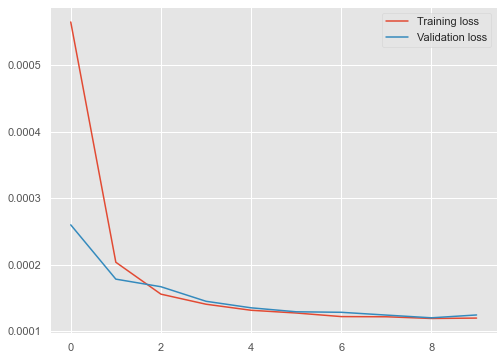

In [192]:
# plot loss function
plt.figure()
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [193]:
predictions = model.predict(x_test)
from math import sqrt

rms1 = (sqrt(mean_squared_error(y_test, predictions)))
print('MAE1', mean_absolute_error(y_test, predictions)) 
print('RMSE1', rms1)

MAE1 0.0051239723168209905
RMSE1 0.011563456896056316


<Figure size 720x432 with 0 Axes>

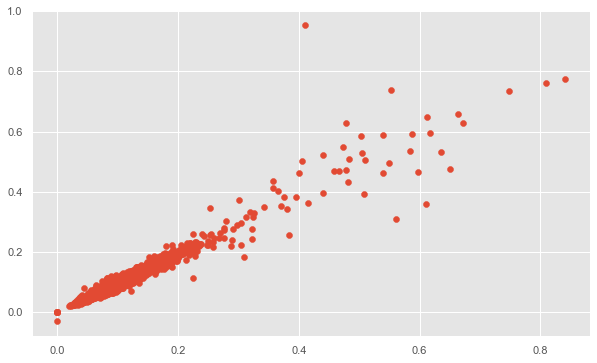

In [194]:
# Faz o scatter plot entre o conjunto de teste e os valores previstos
plt.figure()
plt.figure(figsize=(10, 6))
plt.scatter(y_test,predictions, marker='o')

plt.show()

#Quanto melhor for a previsão, mais concentrado na reta de regressão deve ser os pares dos pontos.

In [195]:
# # inverse scaling and performance metrics

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

#volta a escala original e depois faz comparação com os valores previstos
y1_test=minMax.inverse_transform(y_test.reshape(-1,1))
y1_test=y1_test.squeeze()
pred = model.predict(x[x_train.shape[0]:].reshape(-1, seq_length-1, 1))
pred = minMax.inverse_transform(pred)
pred = pred.squeeze()


In [196]:
#transforma previsões e o conjunto de test em dataframa
pred1 = pd.DataFrame(pred, columns = ['AQI_PRED'])
y1_test1 = pd.DataFrame(y1_test, columns = ['AQI_TEST'])

#como a rede neuronal foi treinada com todos os intervalos de cinco minutos do df original. para que seja possível 
#aproximar a comparação com os outros modelos construídos ao longo do trabalho, reagrupamos as previsões da rede
# a cada 288 entradas, isto é, agrupamos as nossas previsões por dia e fizemos a média para cada um dos dias.

N = 288
pred1 = pred1.groupby(pred1.index // N).mean()
y1_test1 = y1_test1.groupby(y1_test1.index // N).mean()

#Como a divisão do conjunto de teste dos modelos anteriores utilizava apenas os últimos 23 dias do nosso df original, 
#utiliza-se, para calcular as métricas das redes neuronais, os útlimos 23 dias. Isto com o objetivo
#de tornar os modelos mais comparáveis, embora tal método não os torne absolutamente comparáveis,  já o treino dos 
#referidos modelos não tinha a mesma ordem de grandeza e a divisão do conjunto de treino e teste não ocorreu da mesma
#maneira. Isto é, as redes neuronais utilizaram 7876 intervalos de cinco minutos, o que corresponde a aproximadamente
#27 dias para o conjunto de teste e os modelos estocásticos utilizaram 23 dias. 
y1_test1 = y1_test1[-23:]
pred1 = pred1[-23:]

In [197]:
RMSE = sqrt(mean_squared_error(y1_test1, pred1))
RMSE_percent = str(round((sqrt(mean_squared_error(y1_test1, pred1))/y1_test1.mean())*100,2))
print(RMSE)
print(RMSE_percent)

7.008395786964968
AQI_TEST    27.98
dtype: float64


<Figure size 720x432 with 0 Axes>

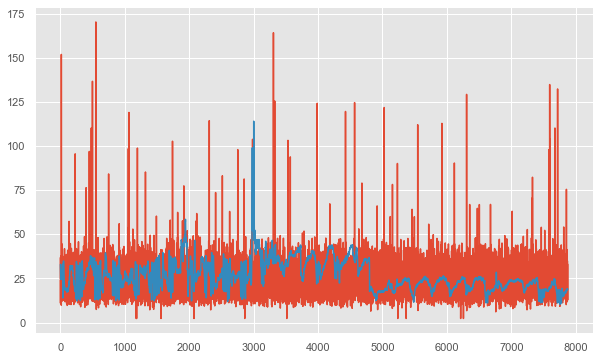

In [198]:
#Está é a série com janelas rolantes, ou seja, há uma espécie de suavização, pelo que é o plot da tendência. 
#Quantos mais valores colocar nas janelas rolantes, mais suavizado será a nossa série prevista, pelo que assim só teremos
#a tendência da série. 

#plot da tendêndia de um subset dos dados
plt.figure()
plt.figure(figsize=(10, 6))
plt.plot(y1_test)
plt.plot(pred)
plt.show()


<Figure size 720x432 with 0 Axes>

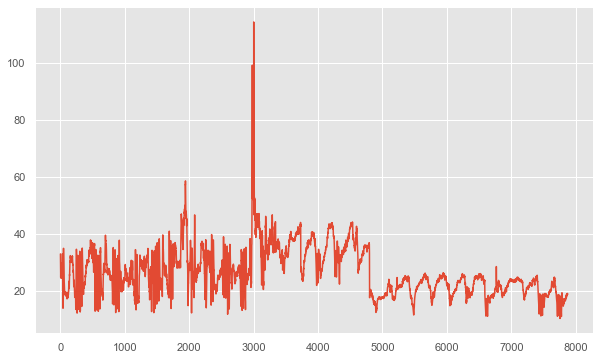

In [199]:
plt.figure()
plt.figure(figsize=(10, 6))
p = model.predict(x[x_train.shape[0]:].reshape(-1, seq_length-1, 1))
p = minMax.inverse_transform(p)
p = p.squeeze()
plt.plot(p)
plt.show()


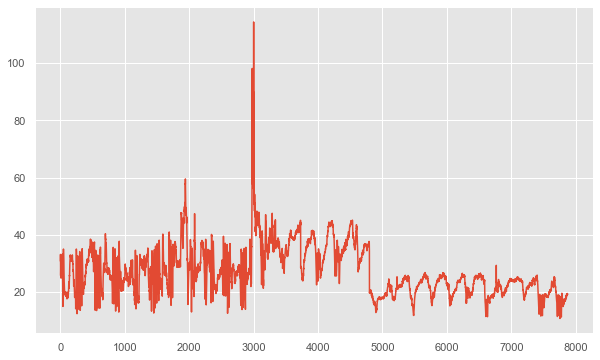

In [200]:
plt.plot(minMax.inverse_transform(y[x_train.shape[0]:].reshape(1,-1)).squeeze())

plt.show()

<Figure size 720x432 with 0 Axes>

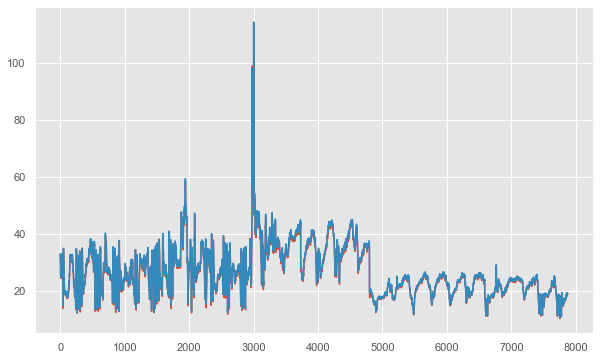

In [201]:
plt.figure()
plt.figure(figsize=(10, 6))
plt.plot(p)
plt.plot(minMax.inverse_transform(y[x_train.shape[0]:].reshape(-1,1)).squeeze())

plt.show()


### Modelo 2 - Com remoção dos outliers e com rolling windows

In [202]:
#Remoção dos outliers

AQI = dfready1["AQI"]
AQI = AQI.to_frame()

for x in ['AQI']:
    q75,q25 = np.percentile(AQI.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    AQI.loc[AQI[x] < min,x] = np.nan
    AQI.loc[AQI[x] > max,x] = np.nan
    
AQI.isnull().sum()
AQI = AQI.dropna(axis = 0)

In [203]:
# Cria regra adicional de aprendizagem através das rolling window. Ou seja, quantos intervalos de 
#cinco minutos são importante para prever o próximo valor. 
seq_length = 12 

minMax = MinMaxScaler()
X = minMax.fit_transform(AQI)

X = X.squeeze() # Aplica-se a transoformação

x = []
y = []
for i in range(len(AQI) - seq_length):
    x.append(X[i: i+(seq_length)-1])
    y.append(X[i+(seq_length)-1])
x = np.array(x)
y = np.array(y)


In [204]:
# check dimension for each set


x_train, x_test, y_train, y_test= train_test_split(x, y)
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(23436, 11)
(7813, 11)
(7813,)
(23436,)


In [205]:
# reshape data
x_train = x_train.reshape(-1, seq_length-1,1)
x_test = x_test.reshape(-1, seq_length-1,1)

In [206]:
#Define arquitetura da rede neuronal artificial
input = Input((seq_length-1, 1))
X = LSTM(150, recurrent_dropout= 0.3)(input) #150 neurónios e #30% de dropout para evitar o overfitting
X= LSTM(150, recurrent_dropout= 0.3)(input) #50 neurónios e #30% de dropout para evitar o overfitting
X= LSTM(100, recurrent_dropout= 0.2)(input)#100 neurónios e #20% de dropout para evitar o overfitting
X = Dense(1)(X) #O output é apenas o 1, ou seja, o AQI e por isso a camada densa é definida como 1 
model = Model(input, X)
model.compile(loss='mse', optimizer= "adam")

In [207]:
# Define dependencia da taxa de aprendizagem
def reduce(epoch, lr):
    if epoch%10 == 0:
        return lr
    return lr
scheduler = LearningRateScheduler(reduce)

In [208]:
#Faz fit do modelo e define o conjunto de validação de 20%
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)
#não utiliza-se as batchs já que a rolling windows foi definido

Epoch 1/10
586/586 [==============================] - 8s 11ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 2/10
586/586 [==============================] - 6s 11ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/10
586/586 [==============================] - 6s 10ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/10
586/586 [==============================] - 6s 10ms/step - loss: 8.9946e-04 - val_loss: 9.1529e-04
Epoch 5/10
586/586 [==============================] - 6s 10ms/step - loss: 8.1820e-04 - val_loss: 0.0012
Epoch 6/10
586/586 [==============================] - 6s 11ms/step - loss: 7.7823e-04 - val_loss: 8.6623e-04 7.
Epoch 7/10
586/586 [==============================] - 6s 11ms/step - loss: 7.4761e-04 - val_loss: 8.2494e-04
Epoch 8/10
586/586 [==============================] - 7s 12ms/step - loss: 7.2884e-04 - val_loss: 8.3114e-04
Epoch 9/10
586/586 [==============================] - 6s 11ms/step - loss: 7.0416e-04 - val_loss: 8.2996e-04
Epoch 10/10
586/586 [=======================

<Figure size 720x432 with 0 Axes>

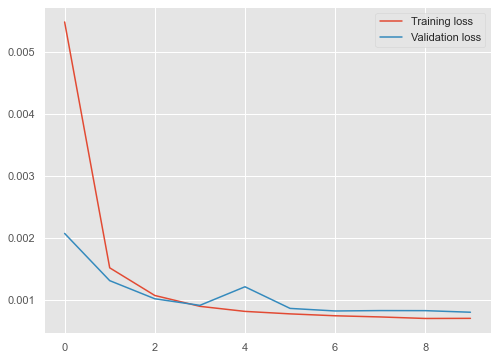

In [209]:
# plot loss function
plt.figure()
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()


In [210]:
predictions = model.predict(x_test)
from math import sqrt

rms1 = (sqrt(mean_squared_error(y_test, predictions)))
print('MAE1', mean_absolute_error(y_test, predictions)) 
print('RMSE1', rms1)


MAE1 0.01627083000834184
RMSE1 0.025999744847862414


<Figure size 720x432 with 0 Axes>

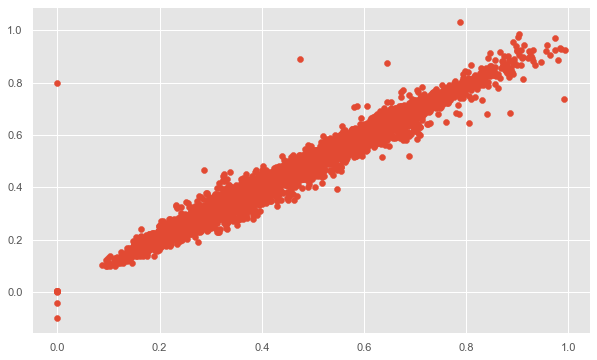

In [211]:
# Faz o scatter plot entre o conjunti de teste e os valores previstos
plt.figure()
plt.figure(figsize=(10, 6))
plt.scatter(y_test,predictions, marker='o')

plt.show()

#Quanto melhor for a previsão, mais concentrado na reta de regressão deve ser os pares dos pontos.

In [212]:
#volta a escala original e depois faz comparação com os valores previstos

y1_test=minMax.inverse_transform(y_test.reshape(-1,1))
y1_test=y1_test.squeeze()

pred = model.predict(x[x_train.shape[0]:].reshape(-1, seq_length-1, 1))
pred = minMax.inverse_transform(pred)
pred = pred.squeeze()


In [213]:
#transforma previsões e o conjunto de test em dataframa
pred = pd.DataFrame(pred, columns = ['AQI_PRED'])
y1_test = pd.DataFrame(y1_test, columns = ['AQI_TEST'])

#como a rede neuronal foi treinada com todos os intervalos de cinco minutos do df original. para que seja possível 
#aproximar a comparação com os outros modelos construídos ao longo do trabalho, reagrupamos as previsões da rede
# a cada 288 entradas, isto é, agrupamos as nossas previsões por dia e fizemos a média para cada um dos dias.

N = 288
pred = pred.groupby(pred.index // N).mean()
y1_test = y1_test.groupby(y1_test.index // N).mean()

#Como a divisão do conjunto de teste dos modelos anteriores utilizava apenas os últimos 23 dias do nosso df original, 
#utiliza-se, para calcular as métricas das redes neuronais, os útlimos 23 dias. Isto com o objetivo
#de tornar os modelos mais comparáveis, embora tal método não os torne absolutamente comparáveis,  já o treino dos 
#referidos modelos não tinha a mesma ordem de grandeza e a divisão do conjunto de treino e teste não ocorreu da mesma
#maneira. Isto é, as redes neuronais utilizaram 7876 intervalos de cinco minutos, o que corresponde a aproximadamente
#27 dias para o conjunto de teste e os modelos estocásticos utilizaram 23 dias. 
y1_test = y1_test[-23:]
pred = pred[-23:]

In [214]:
RMSE = sqrt(mean_squared_error(y1_test, pred))
RMSE_percent = str(round((sqrt(mean_squared_error(y1_test, pred))/y1_test.mean())*100,2))
print(RMSE)
print(RMSE_percent)

7.000396159831488
AQI_TEST    28.35
dtype: float64


<Figure size 720x432 with 0 Axes>

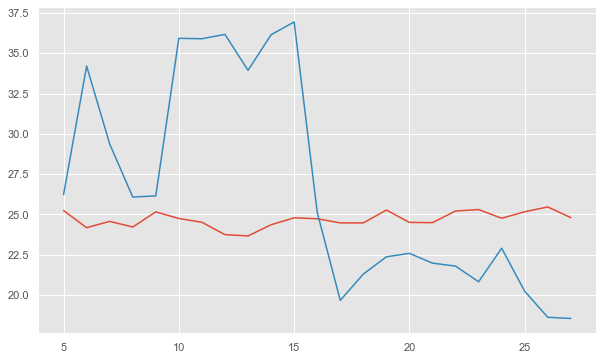

In [215]:
#Está é a série com janelas rolantes, ou seja, há uma espécie de suavização, pelo que é o plot da tendência. 
#Quantos mais valores colocar nas janelas rolantes, mais suavizado será a nossa série prevista, pelo que assim só teremos
#a tendência da série. 

plt.figure()
plt.figure(figsize=(10, 6))
plt.plot(y1_test)
plt.plot(pred)
plt.show()

# #### ploting subset from the data



<Figure size 720x432 with 0 Axes>

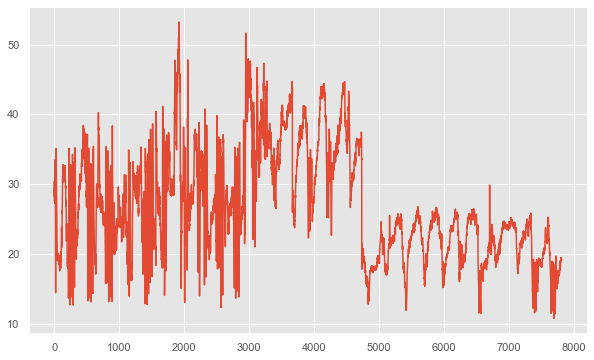

In [216]:

plt.figure()
plt.figure(figsize=(10, 6))
p = model.predict(x[x_train.shape[0]:].reshape(-1, seq_length-1, 1))
p = minMax.inverse_transform(p)
p = p.squeeze()
plt.plot(p)
plt.show()




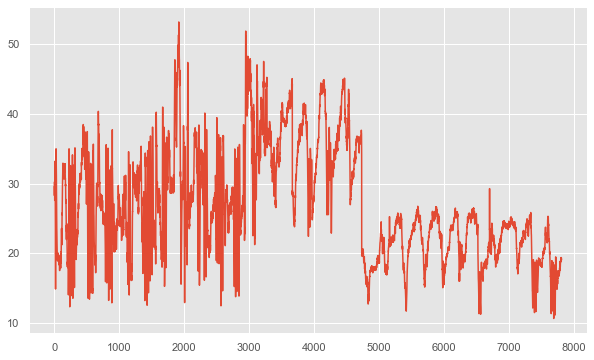

In [217]:
plt.plot(minMax.inverse_transform(y[x_train.shape[0]:].reshape(1,-1)).squeeze())

plt.show()

<Figure size 720x432 with 0 Axes>

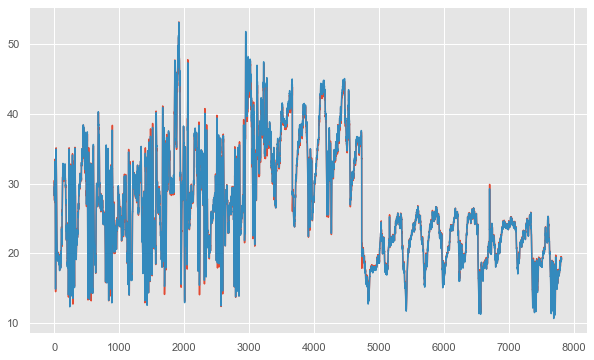

In [218]:
plt.figure()
plt.figure(figsize=(10, 6))
plt.plot(p)
plt.plot(minMax.inverse_transform(y[x_train.shape[0]:].reshape(-1,1)).squeeze())

plt.show()
